## Python Code to obtain mesh for 3D modelling

## Phase 1: Environment Preparation
1. Virtual Environment Setup with Python (Anaconda)
2. Installing Base Libraries: Numpy, Pandas, Matplotlib
3. Installing 3D Libraries: Rasterio, Alphashape, Geopandas, Shapely
4. Installing IDE (Jupyter Lab)

In [1]:
#Base libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#3D Libraries
import open3d as o3d
import laspy
print(laspy.__version__)

2.5.4


In [3]:
#Geospatial libraries
import rasterio
import alphashape as ash
import geopandas as gpd
import shapely as sh

In [4]:
#Importing Some Specific Function from the Libraries
from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.features import shapes
from shapely.geometry import Polygon

## Phase 2: Data Preparation
1. Aerial LiDAR Data Curation: [Vancouver LiDAR Dataset](https://opendata.vancouver.ca/explore/dataset/lidar-2022/map/?location=13,49.25201,-123.17348)
2. Data Profiling
3. Data Pre-Processing

---
#### 1. Data Curation
1. Download data
2. Study classes of the Data

---
#### Classes in Point Cloud
1. Unclassified
2. Bare-earth and low grass
3. Low vegetation (height < 2m)
4. High vegetation (height > 2m)
5. Water
6. Buildings
7. Other and
8. Noise (noise points, blunders, outliners, etc)

---
#### 2. Data Profiling

In [5]:
#Reading the point cloud (i.e. LiDAR Data)
las = laspy.read('/Users/aaryanbabuta/Documents/LiDAR Project/neighborhood.laz')

In [6]:
#Explore the Classification field
print(np.unique(las.classification))
print('\n')
print([dimension.name for dimension in las.point_format.dimensions])

[1 2 3 5 6 7]


['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue']


In [7]:
#Explore CRS info
crs = las.vlrs[2].string
print(las.vlrs[2].string)

PROJCS["NAD_1983_UTM_Zone_10N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-123.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0],AUTHORITY["EPSG",26910]]


---
#### 3. Data Pre-Processing

3.1. Building Points initialization

In [8]:
# Create a Mask to filter points
pts_mask = las.classification == 6

In [9]:
#Apply the mask and get the coordinates of the filtered dataset (note the t for transpose)
xyz_t = np.vstack((las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]))

In [10]:
#Transform to Open3D.o3d.geometry.PointCloud and visualize
pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(xyz_t.transpose())

In [11]:
#Translate the point cloud, and keep the translation to reapply at the end
pcd_center = pcd_o3d.get_center()
pcd_o3d.translate(-pcd_center)

PointCloud with 165921 points.

In [12]:
#Visualize the results
o3d.visualization.draw_geometries([pcd_o3d])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


2024-09-26 00:19:29.032 python[5146:153685] +[IMKClient subclass]: chose IMKClient_Legacy
2024-09-26 00:19:29.032 python[5146:153685] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


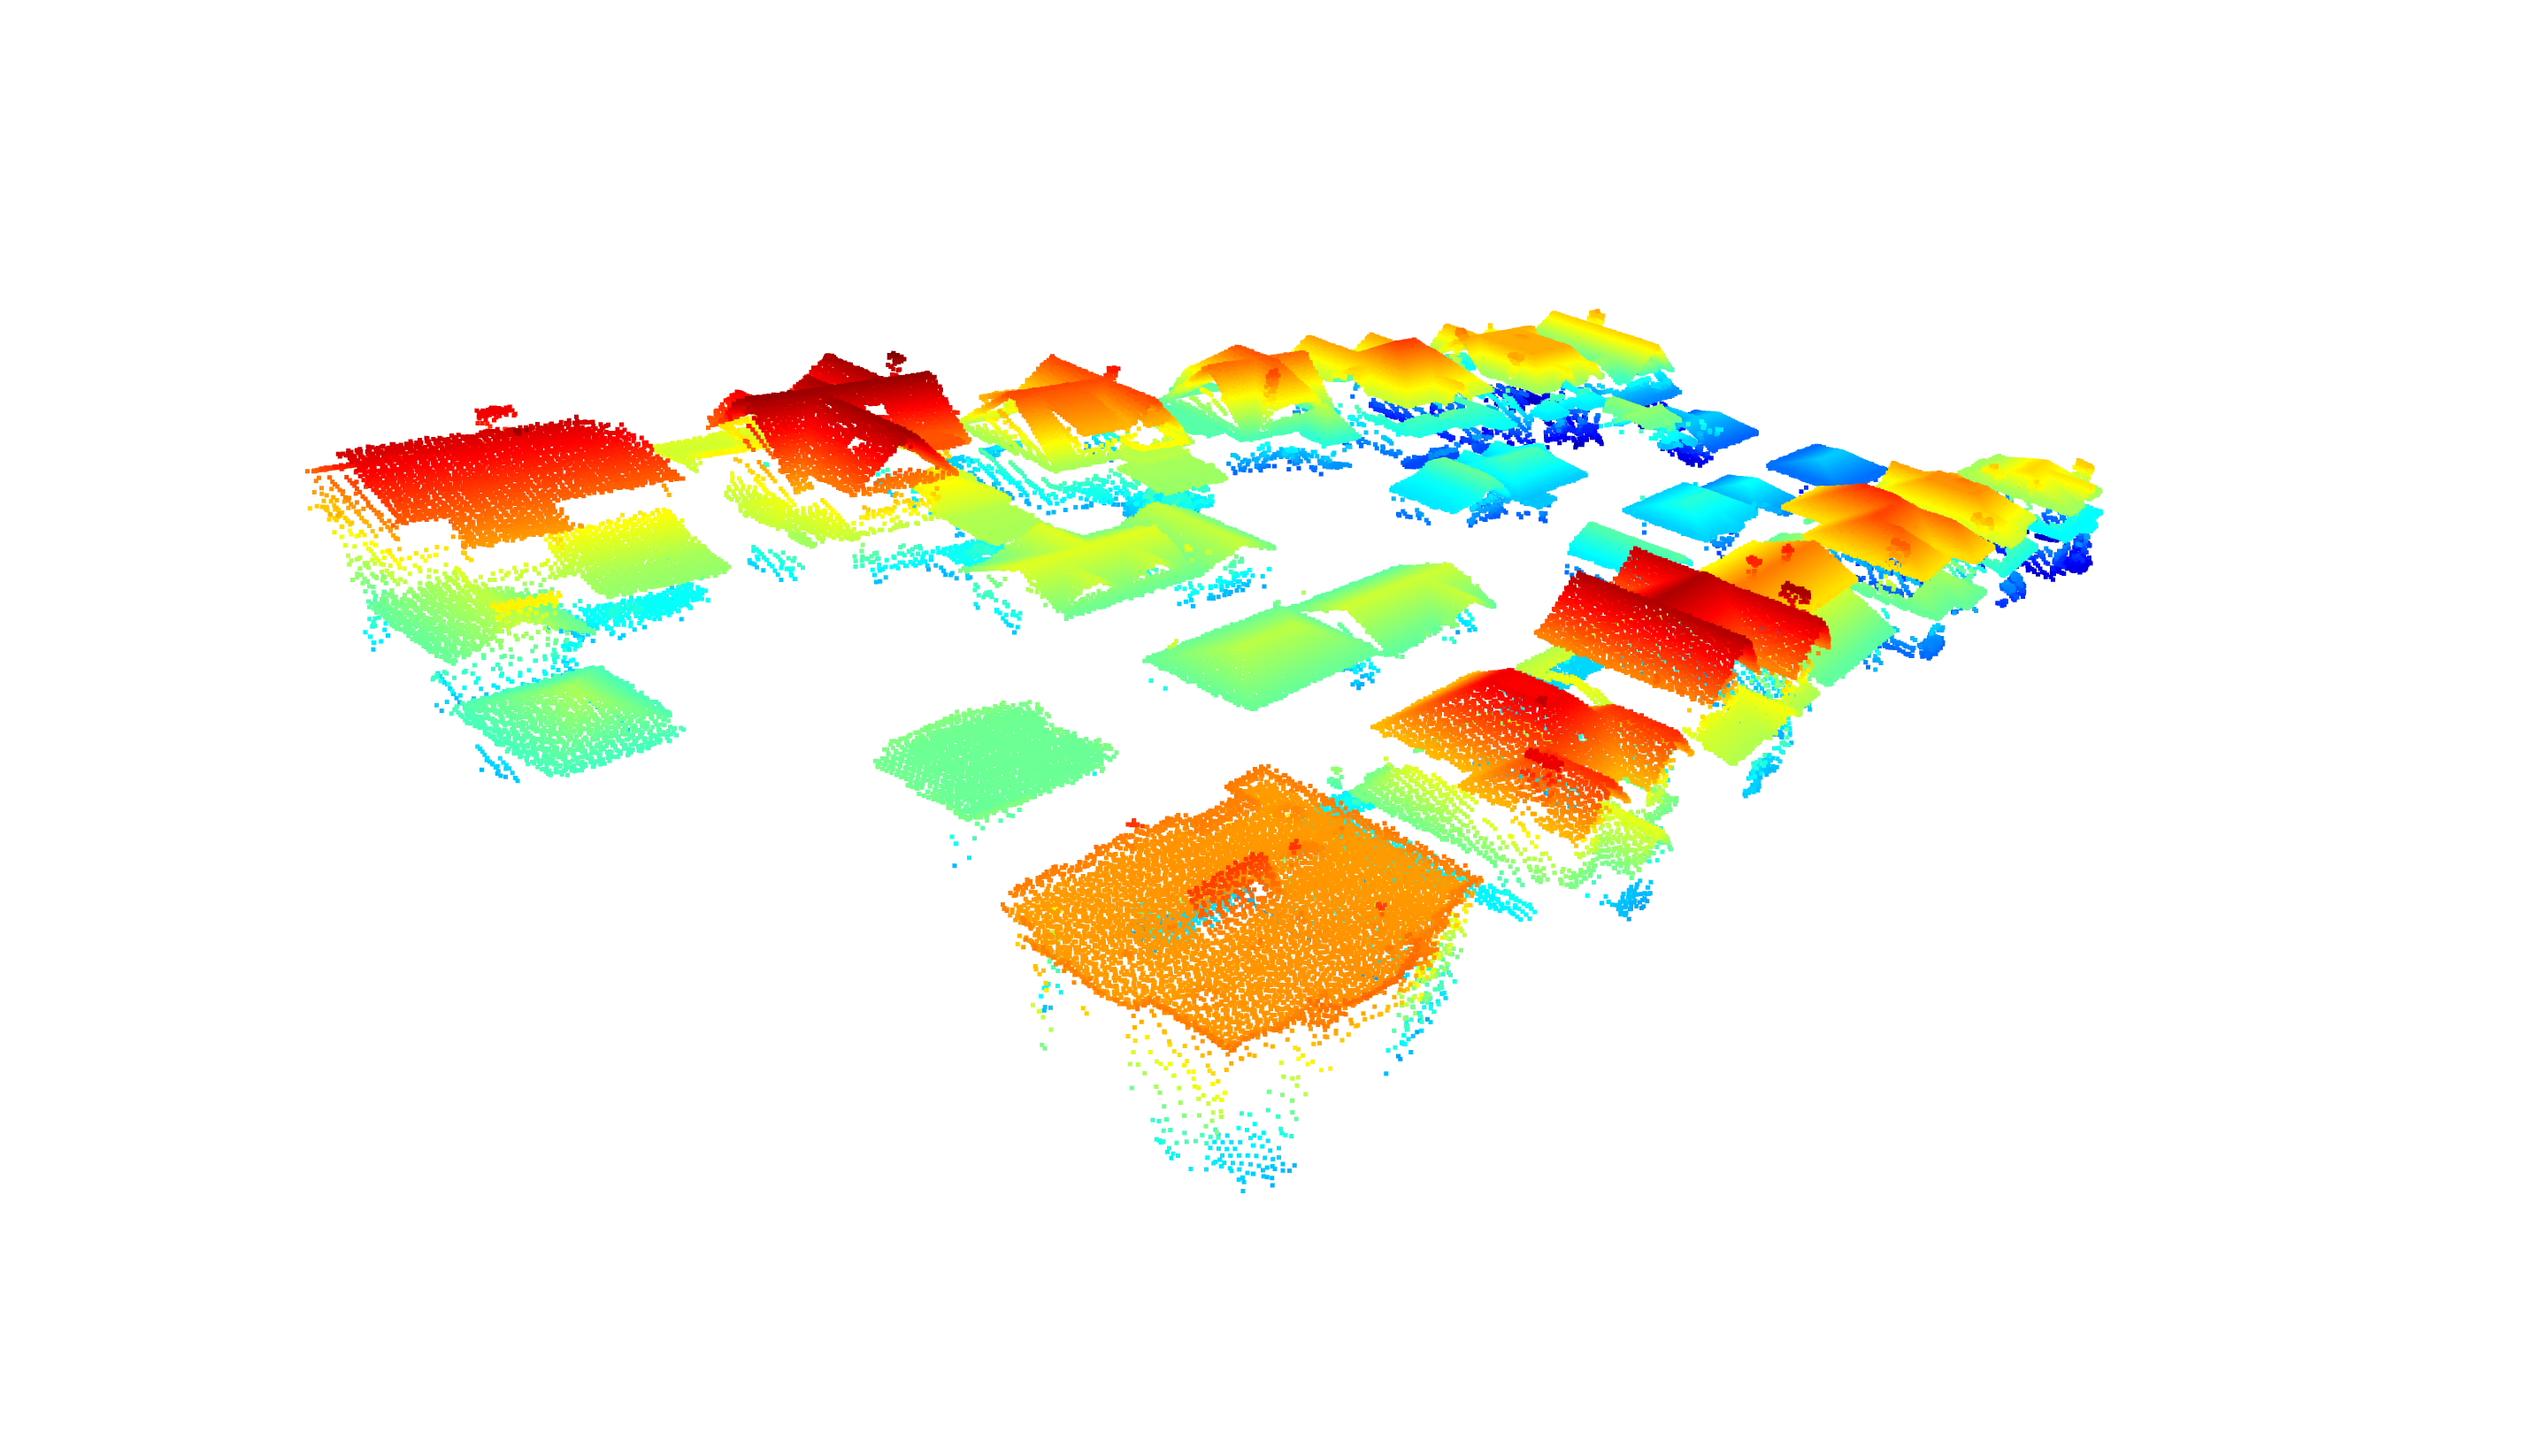

3.2. Idetifying the average distance between the building points

In [13]:
pts_mask = las.classification == 2
xyz_t = np.vstack((las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]))

ground_pts = o3d.geometry.PointCloud()
ground_pts.points = o3d.utility.Vector3dVector(xyz_t.transpose())
ground_pts.translate(-pcd_center)

PointCloud with 170219 points.

In [14]:
#Visualize the results
o3d.visualization.draw_geometries([ground_pts])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


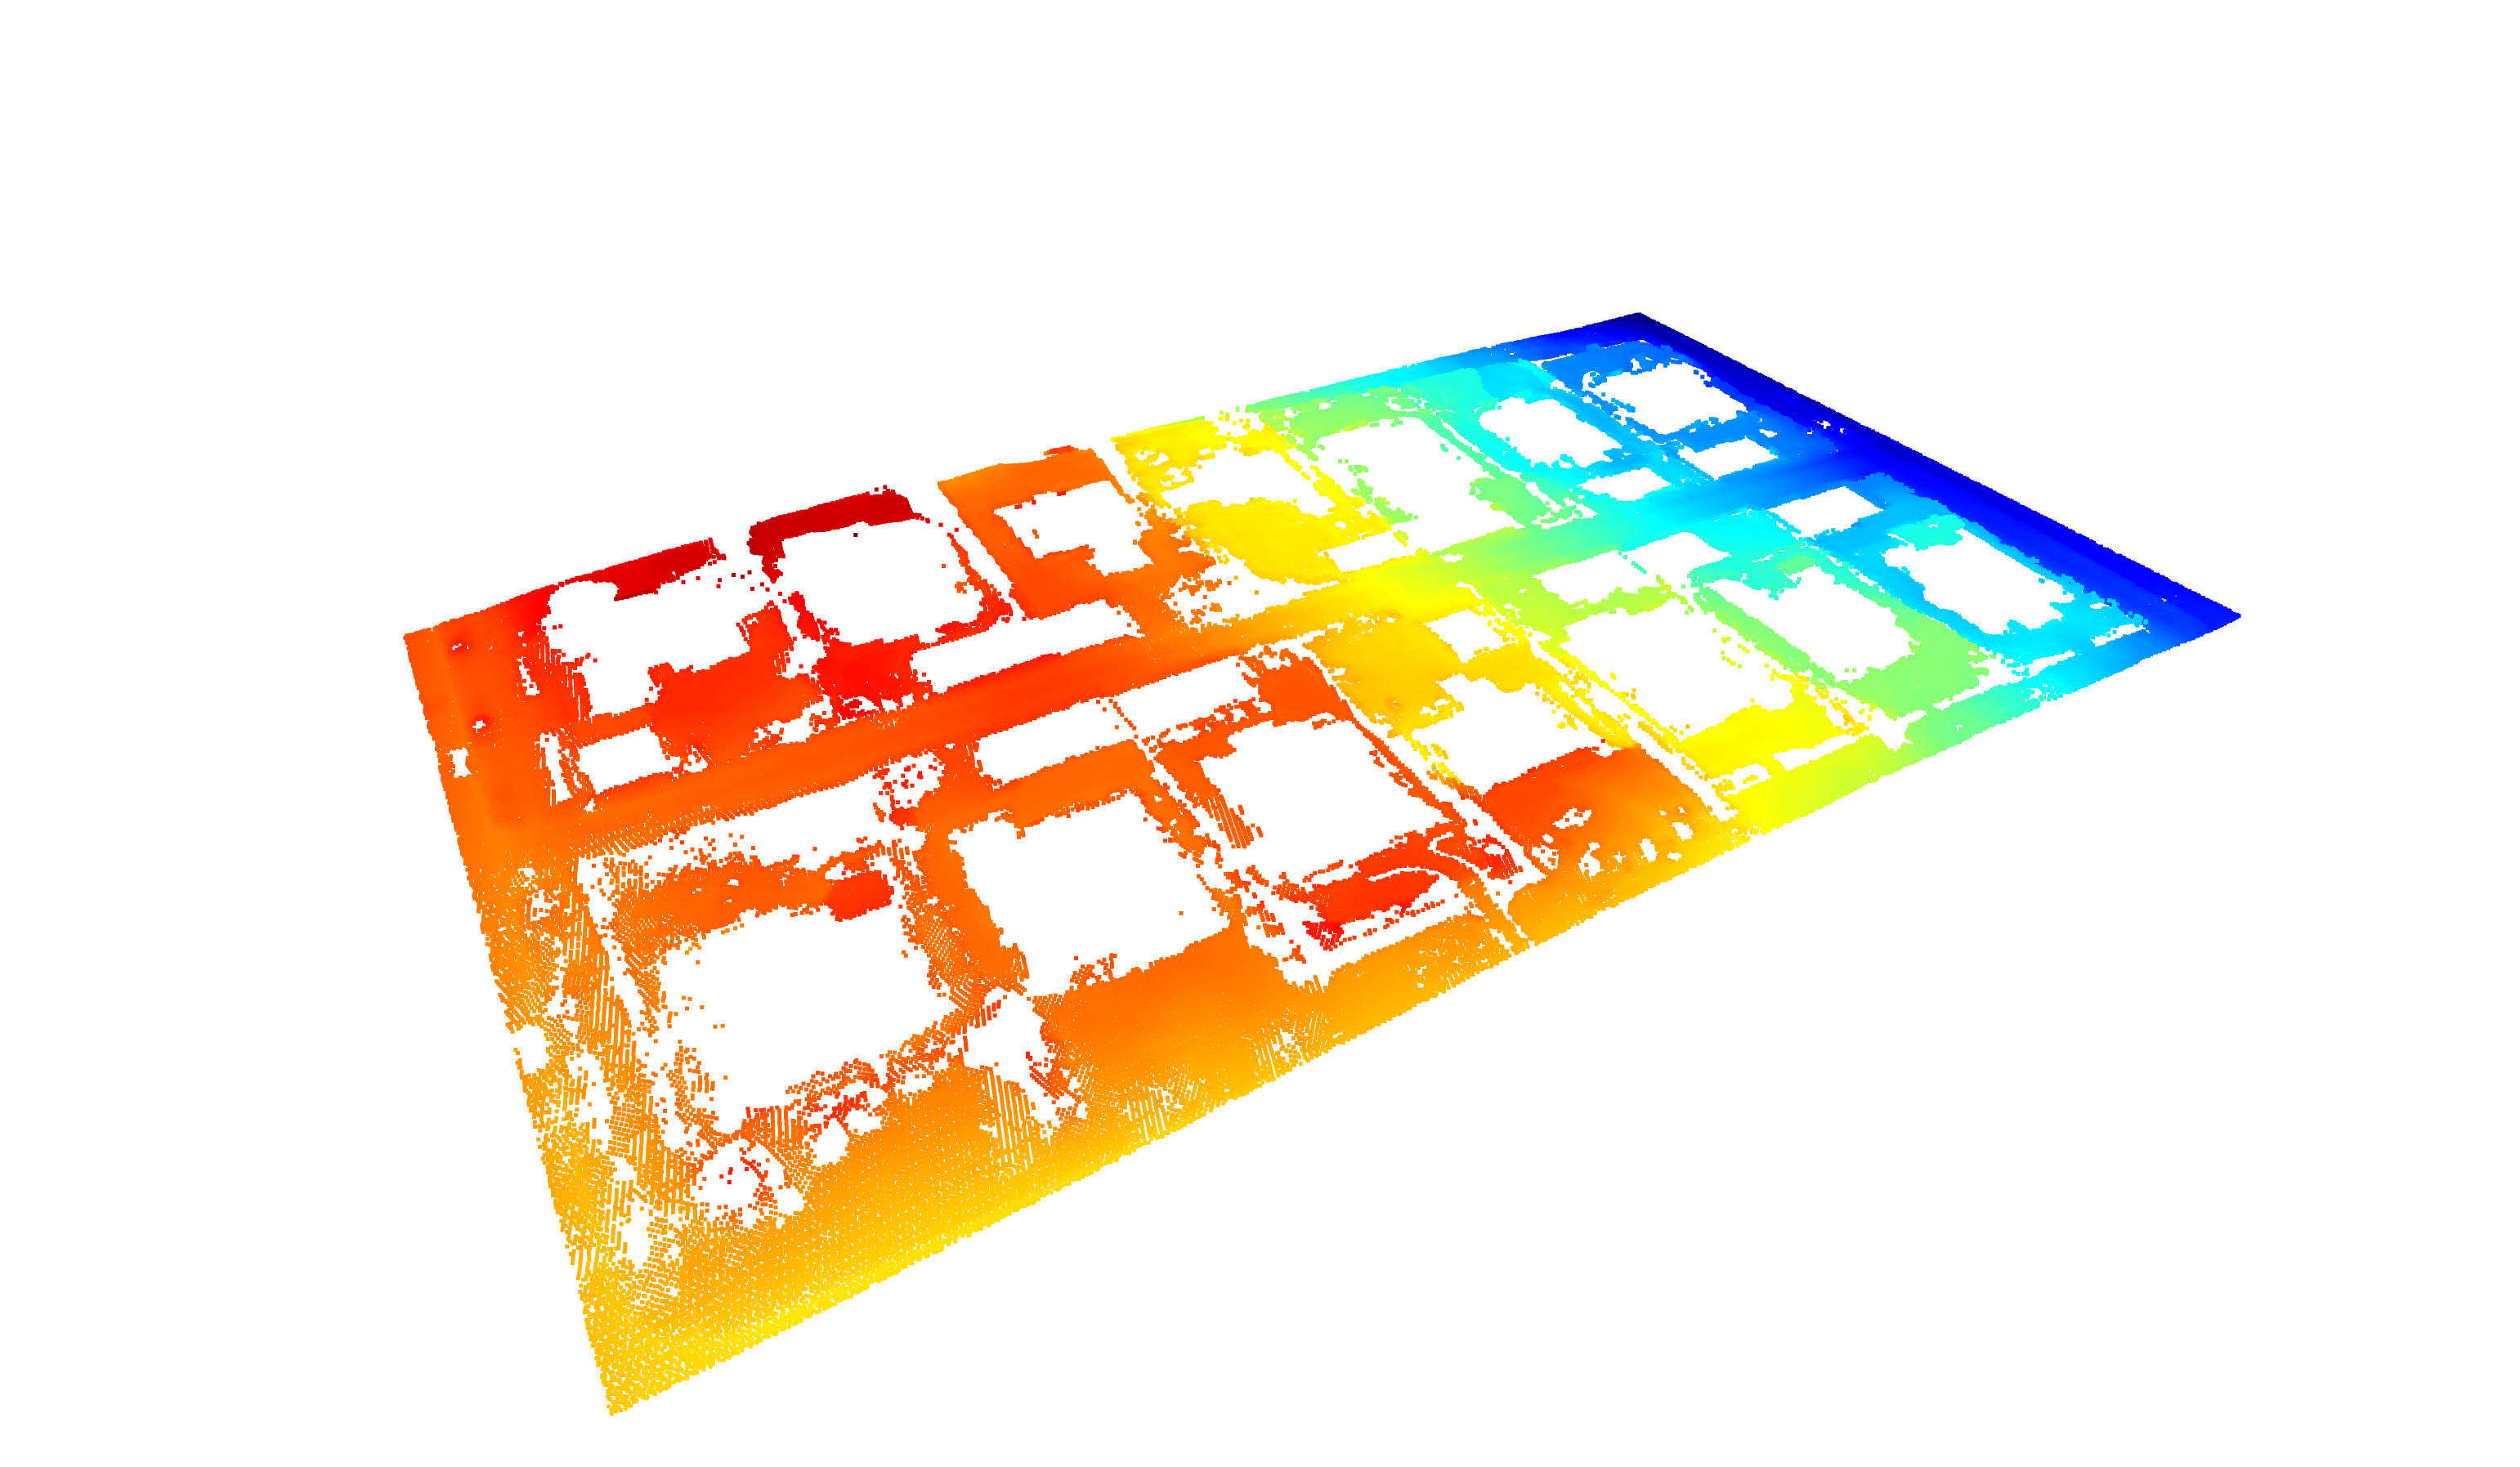

3.2. Identifying the average distance between building points

In [15]:
nn_distance = np.mean(pcd_o3d.compute_nearest_neighbor_distance())
print("average point distance (m): ", nn_distance)

average point distance (m):  0.11673857611056317


## Phase 3: Single Unit Experiments
 4. Unsupervised segmentation
 5. 3D House Segmentation
 6. 2D Building footprint extraction
 7. Semantic and Attribute Extraction
 8. 2D to 3D Vectors
 9. 3D Model Creation (vertices)
 10. 3D Model Creation (meshes)
 11. Post-Processing and Export

#### 4. Unsupervised Segmentation (Clustering) with DBSCAN

In [16]:
#We are now working in a local frame of reference, essential not to get stuck at truncated coordinates

#Definition of the parameters epsilon, and the minimum number of points to be considered a relevant cluster
epsilon = 2
min_cluster_points = 100

labels = np.array(pcd_o3d.cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")

point cloud has 31 clusters


In [17]:
#We use a discrete color palette to randomize the visualization
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd_o3d.colors = o3d.utility.Vector3dVector(colors[:, :3])

In [18]:
#Point Cloud Visualization
o3d.visualization.draw_geometries([pcd_o3d])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


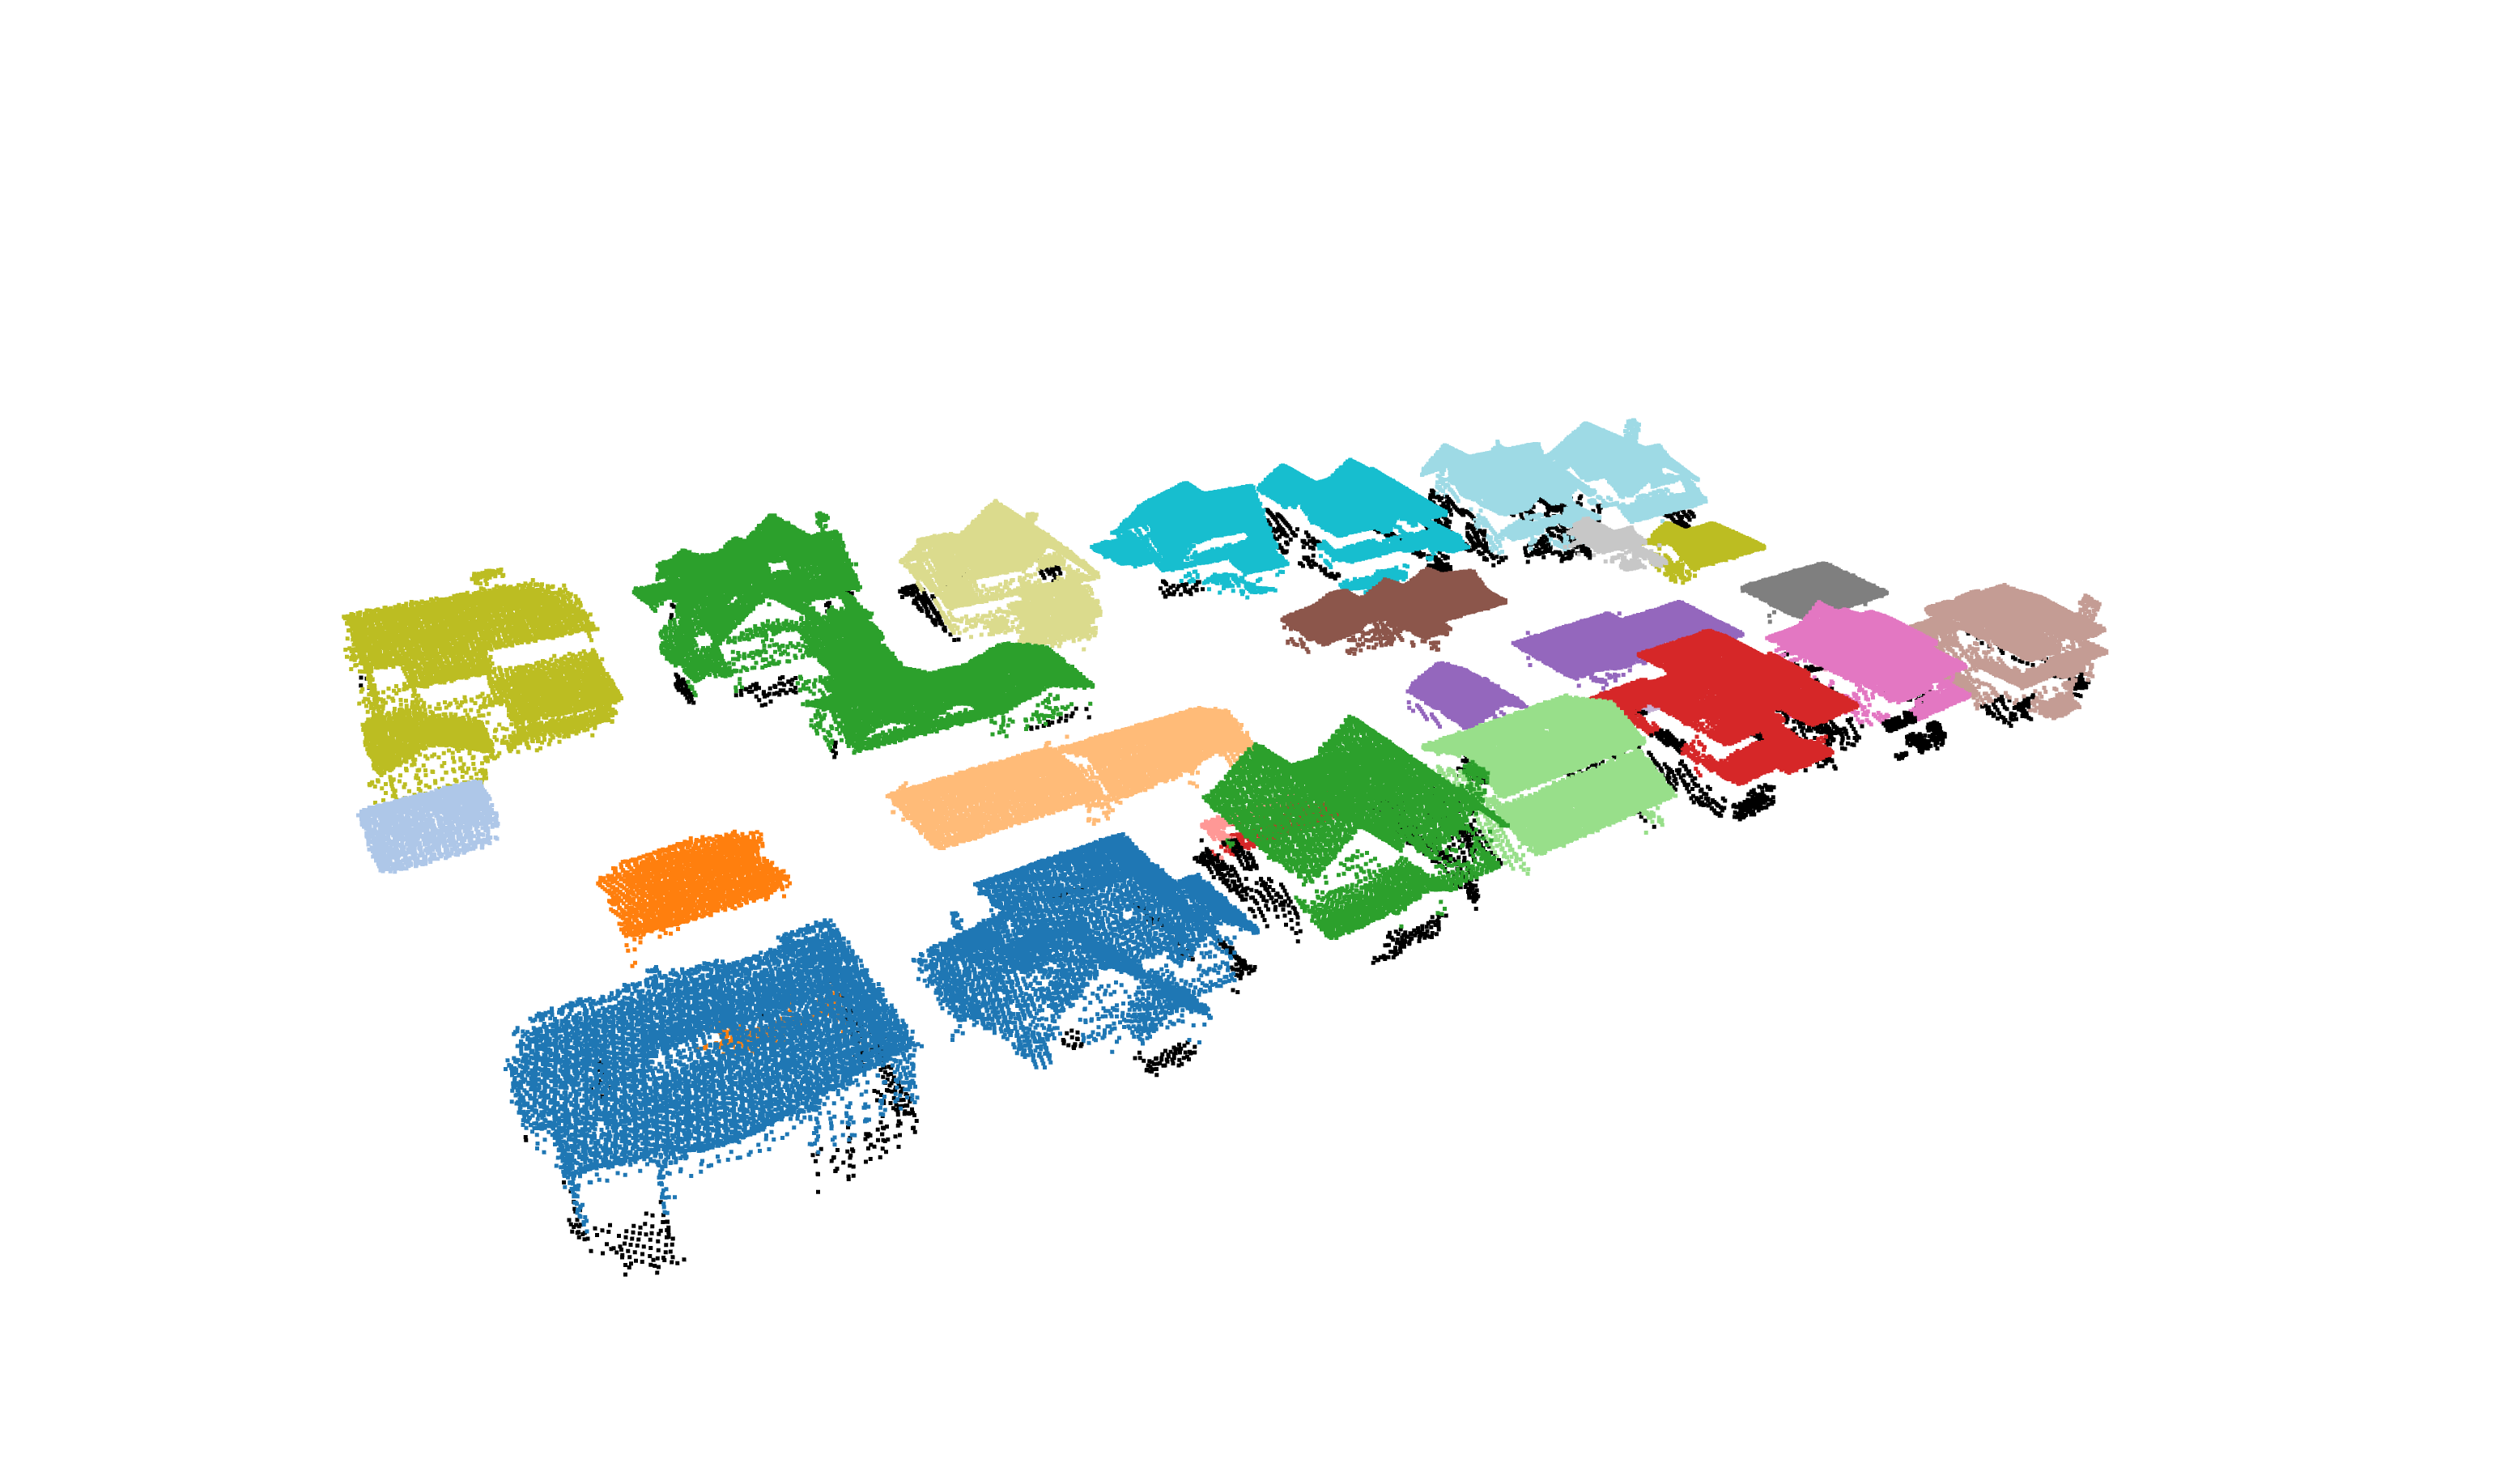

#### 5. Selecting a segment to be considered

In [21]:
sel = 0
segment = pcd_o3d.select_by_index(np.where(labels==sel)[0])

In [ ]:
#Point Cloud Visualization
o3d.visualization.draw_geometries([segment])

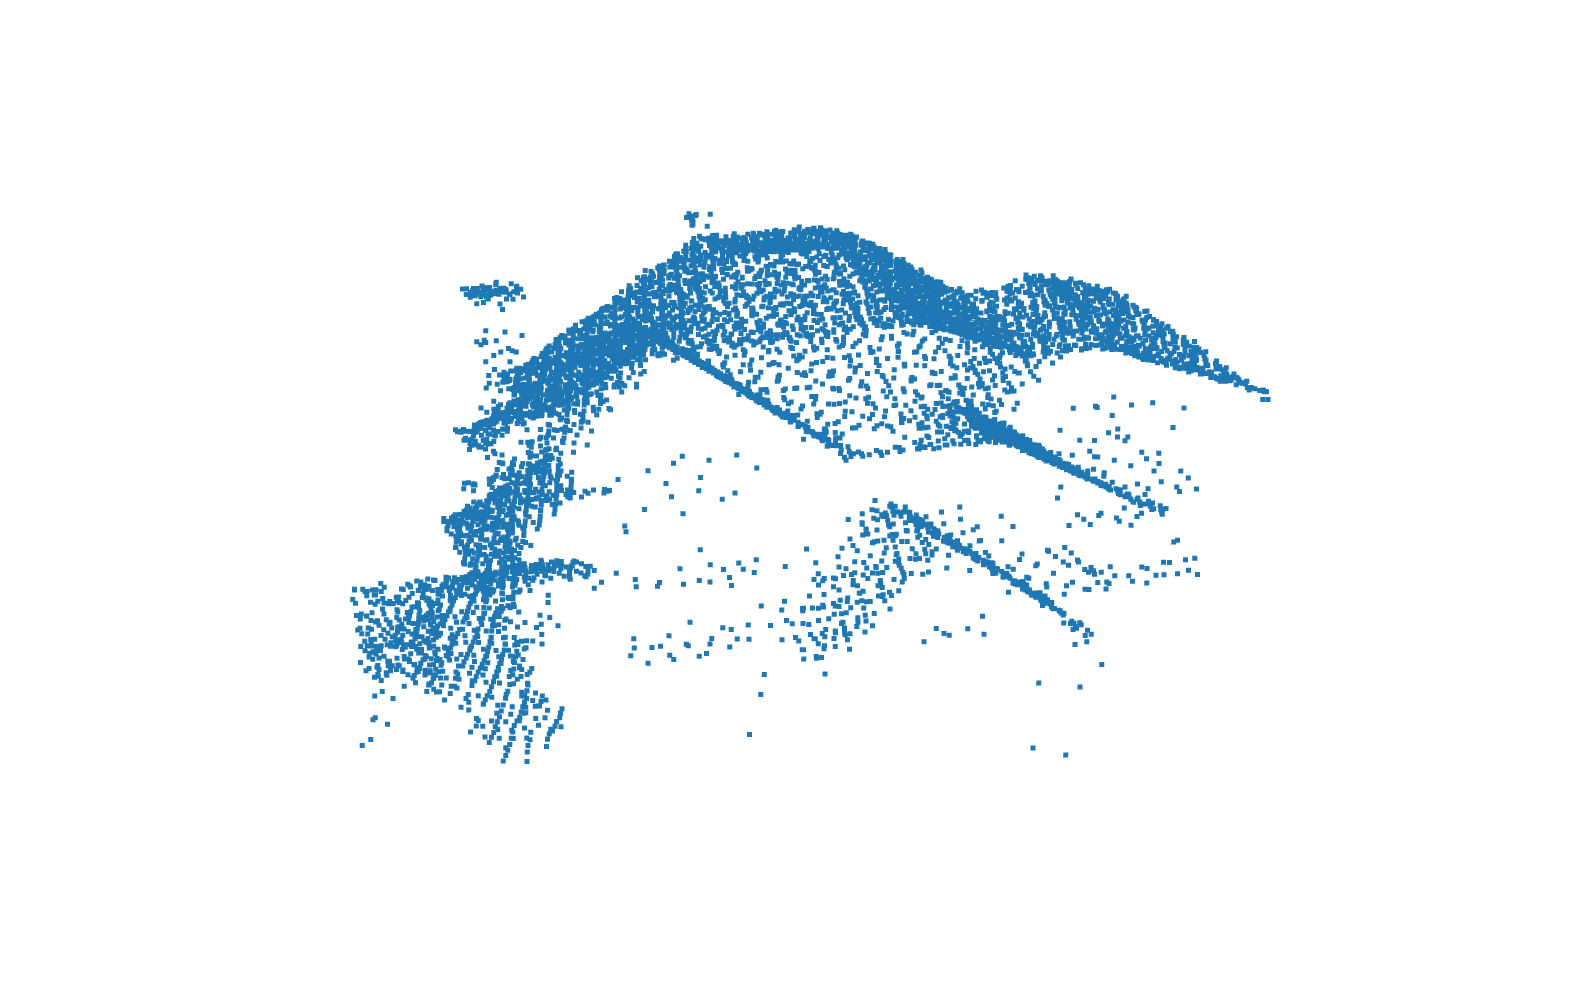

#### 6. Extracting the outline (building footprint) of the selection

In [21]:
#We extract only the X and Y coordinates of our point cloud (Note: it is local)
points_2D = np.asarray(segment.points)[:,0:2]

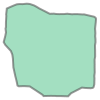

In [22]:
#We compute the shape (alpha shape) and return the result with shapely
building_vector = ash.alphashape(points_2D, alpha=0.5)
building_vector

In [23]:
# Store the 2D polygon in a Geodataframe 
building_gdf = gpd.GeoDataFrame(geometry=[building_vector], crs='EPSG:26910')
building_gdf.head(1)

geometry
0  POLYGON ((-42.952 -15.99, -42.499 -16.049, -41...

#### 7. Computing Semantics and Attributes

7.1 The height of the building as a relative measure

In [24]:
#The results produced are not so accurate through this method
altitude = np.asarray(segment.points)[:,2]+pcd_center[2]
height_test = np.max(altitude)- np.min(altitude)
print('height test:',height_test)

height test: 10.192000000000007


In [25]:
#We first have to define the ground level in our local area
query_point = segment.get_center()
query_point[2] = segment.get_min_bound()[2]
pcd_tree = o3d.geometry.KDTreeFlann(ground_pts)
[k, idx, _] = pcd_tree.search_knn_vector_3d(query_point, 200)

In [26]:
#From the nn search, we extract the points that belong to the ground and paint them grey
sample = ground_pts.select_by_index(idx, invert=False)
sample.paint_uniform_color([0.5, 0.5, 0.5])

PointCloud with 200 points.

In [27]:
o3d.visualization.draw_geometries([sample, ground_pts])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [28]:
#Extract the mean value of the ground in this specific place
ground_zero = sample.get_center()[2]

#Compute the true height of the building, roof included:
height = segment.get_max_bound()[2] - ground_zero
print('True Height: ', height)

#Check the difference: 
print('Height Difference between test height and true height: ', height - height_test)

True Height:  10.070570000000004
Height Difference between test height and true height:  -0.1214300000000037


---
7.2. Computing Parameters

In [29]:
building_gdf[['id']] = sel
building_gdf[['height']] = segment.get_max_bound()[2] - sample.get_center()[2]
building_gdf[['area']] = building_vector.area
building_gdf[['perimeter']] = building_vector.length
building_gdf[['local_cx','local_cy','local_cz']] = np.asarray([building_vector.centroid.x, building_vector.centroid.y, sample.get_center()[2]])
building_gdf[['transl_x','transl_y','transl_z']] = pcd_center
building_gdf[['pts_number']] = len(segment.points)

building_gdf.head(1)

geometry  id    height  \
0  POLYGON ((-42.952 -15.99, -42.499 -16.049, -41...   1  10.07057   

         area  perimeter  local_cx   local_cy  local_cz       transl_x  \
0  217.271398  58.079869 -43.39485 -22.418669 -4.426159  490276.695828   

       transl_y    transl_z  pts_number  
0  5.453749e+06  109.171589        7747

---
7.3. Extra Attributes

In [30]:
points_1D = np.asarray(segment.points)[:,2]
print('The local minima (along the Z axis)',np.min(points_1D))
print('The local maxima (along the Z axis)',np.max(points_1D))

The local minima (along the Z axis) -4.54758912976655
The local maxima (along the Z axis) 5.6444108702334574


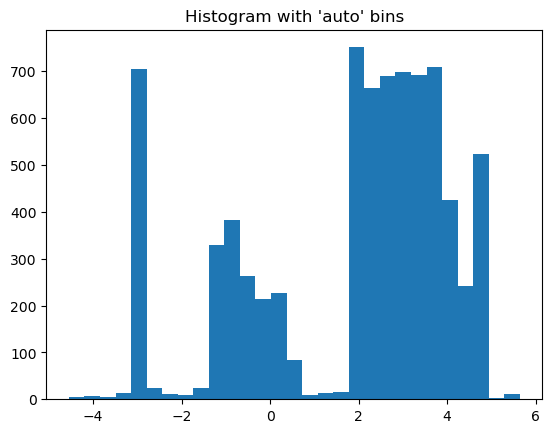

In [31]:
plt.hist(points_1D, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

#### 8. 2D to 3D Library: From a shapely Vector dataset to an Open3D LineSet

8.1. The base layer

In [32]:
#Generate the vertice list
vertices = list(building_vector.exterior.coords)

In [33]:
#Construct the Open3D Object
polygon_2d = o3d.geometry.LineSet()
polygon_2d.points = o3d.utility.Vector3dVector([point + (0,) for point in vertices])
polygon_2d.lines = o3d.utility.Vector2iVector([(i, (i + 1) % len(vertices)) for i in range(len(vertices))])

In [34]:
#Visualization
o3d.visualization.draw_geometries([polygon_2d])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


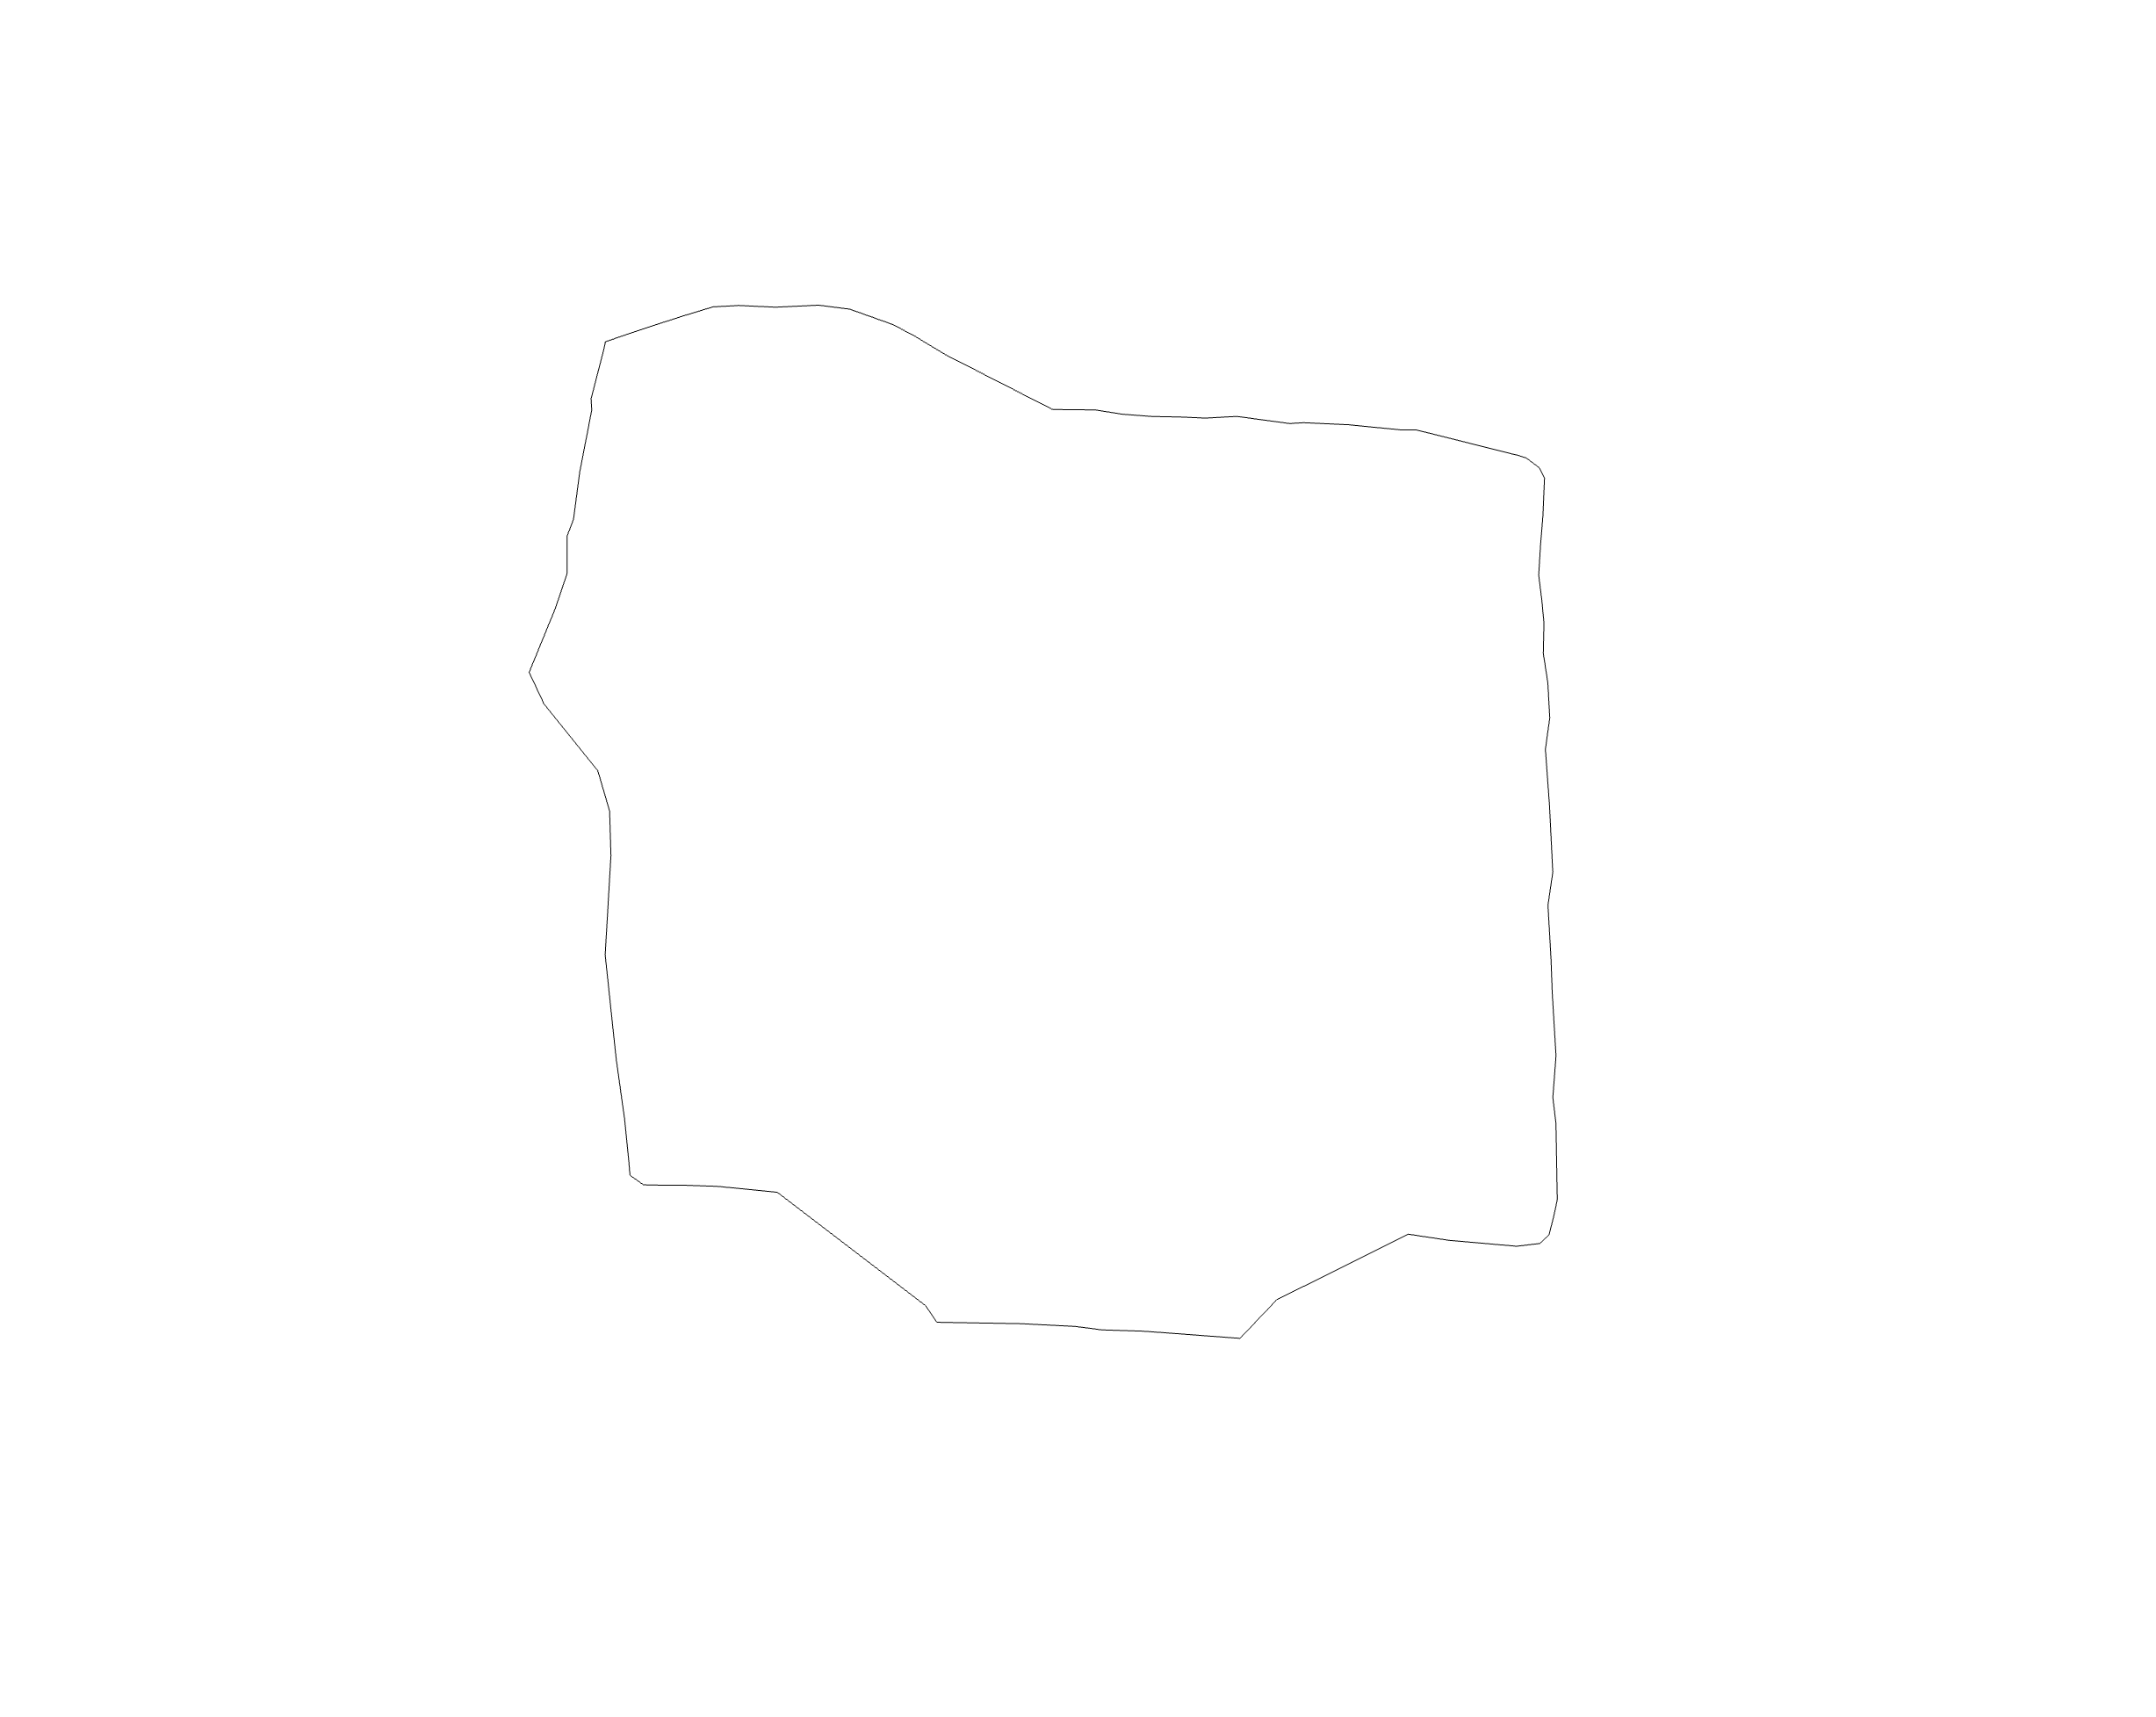

8.2. The top layer

In [35]:
#Generate the same element for the Extruded
extrusion = o3d.geometry.LineSet()
extrusion.points = o3d.utility.Vector3dVector([point + (height,) for point in vertices])
extrusion.lines = o3d.utility.Vector2iVector([(i, (i + 1) % len(vertices)) for i in range(len(vertices))])

In [36]:
#Visualize
o3d.visualization.draw_geometries([polygon_2d, extrusion])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


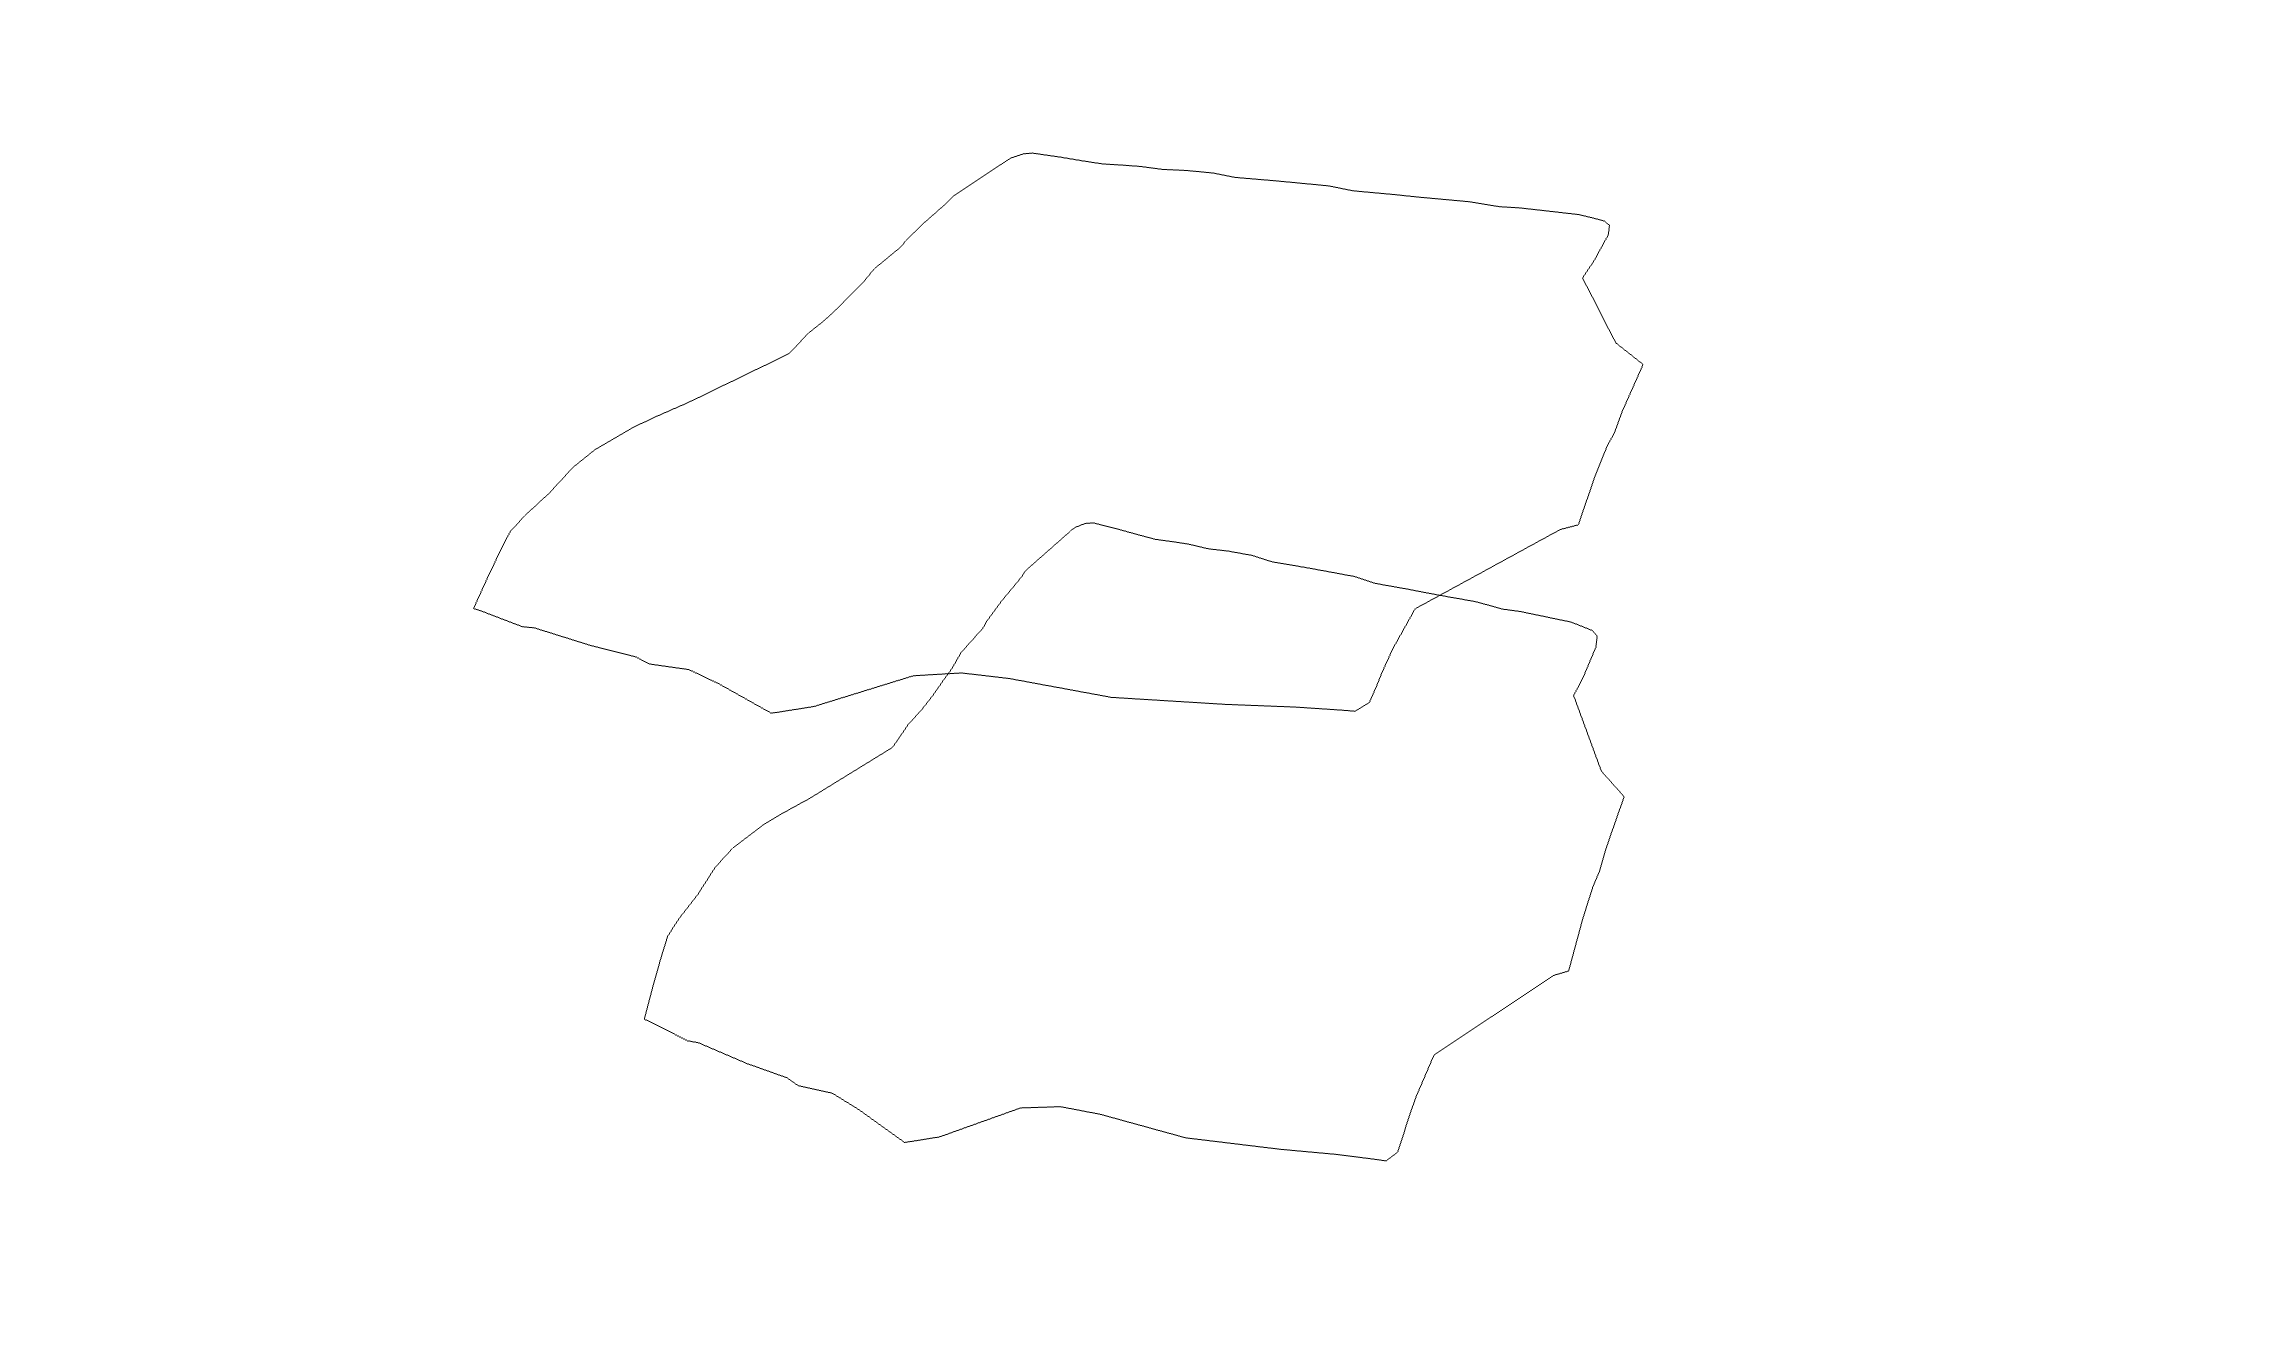

In [37]:
#Plot the vertices
temp = polygon_2d + extrusion
temp.points
temp_o3d = o3d.geometry.PointCloud()
temp_o3d.points = temp.points

In [38]:
#Visualise
o3d.visualization.draw_geometries([temp_o3d])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


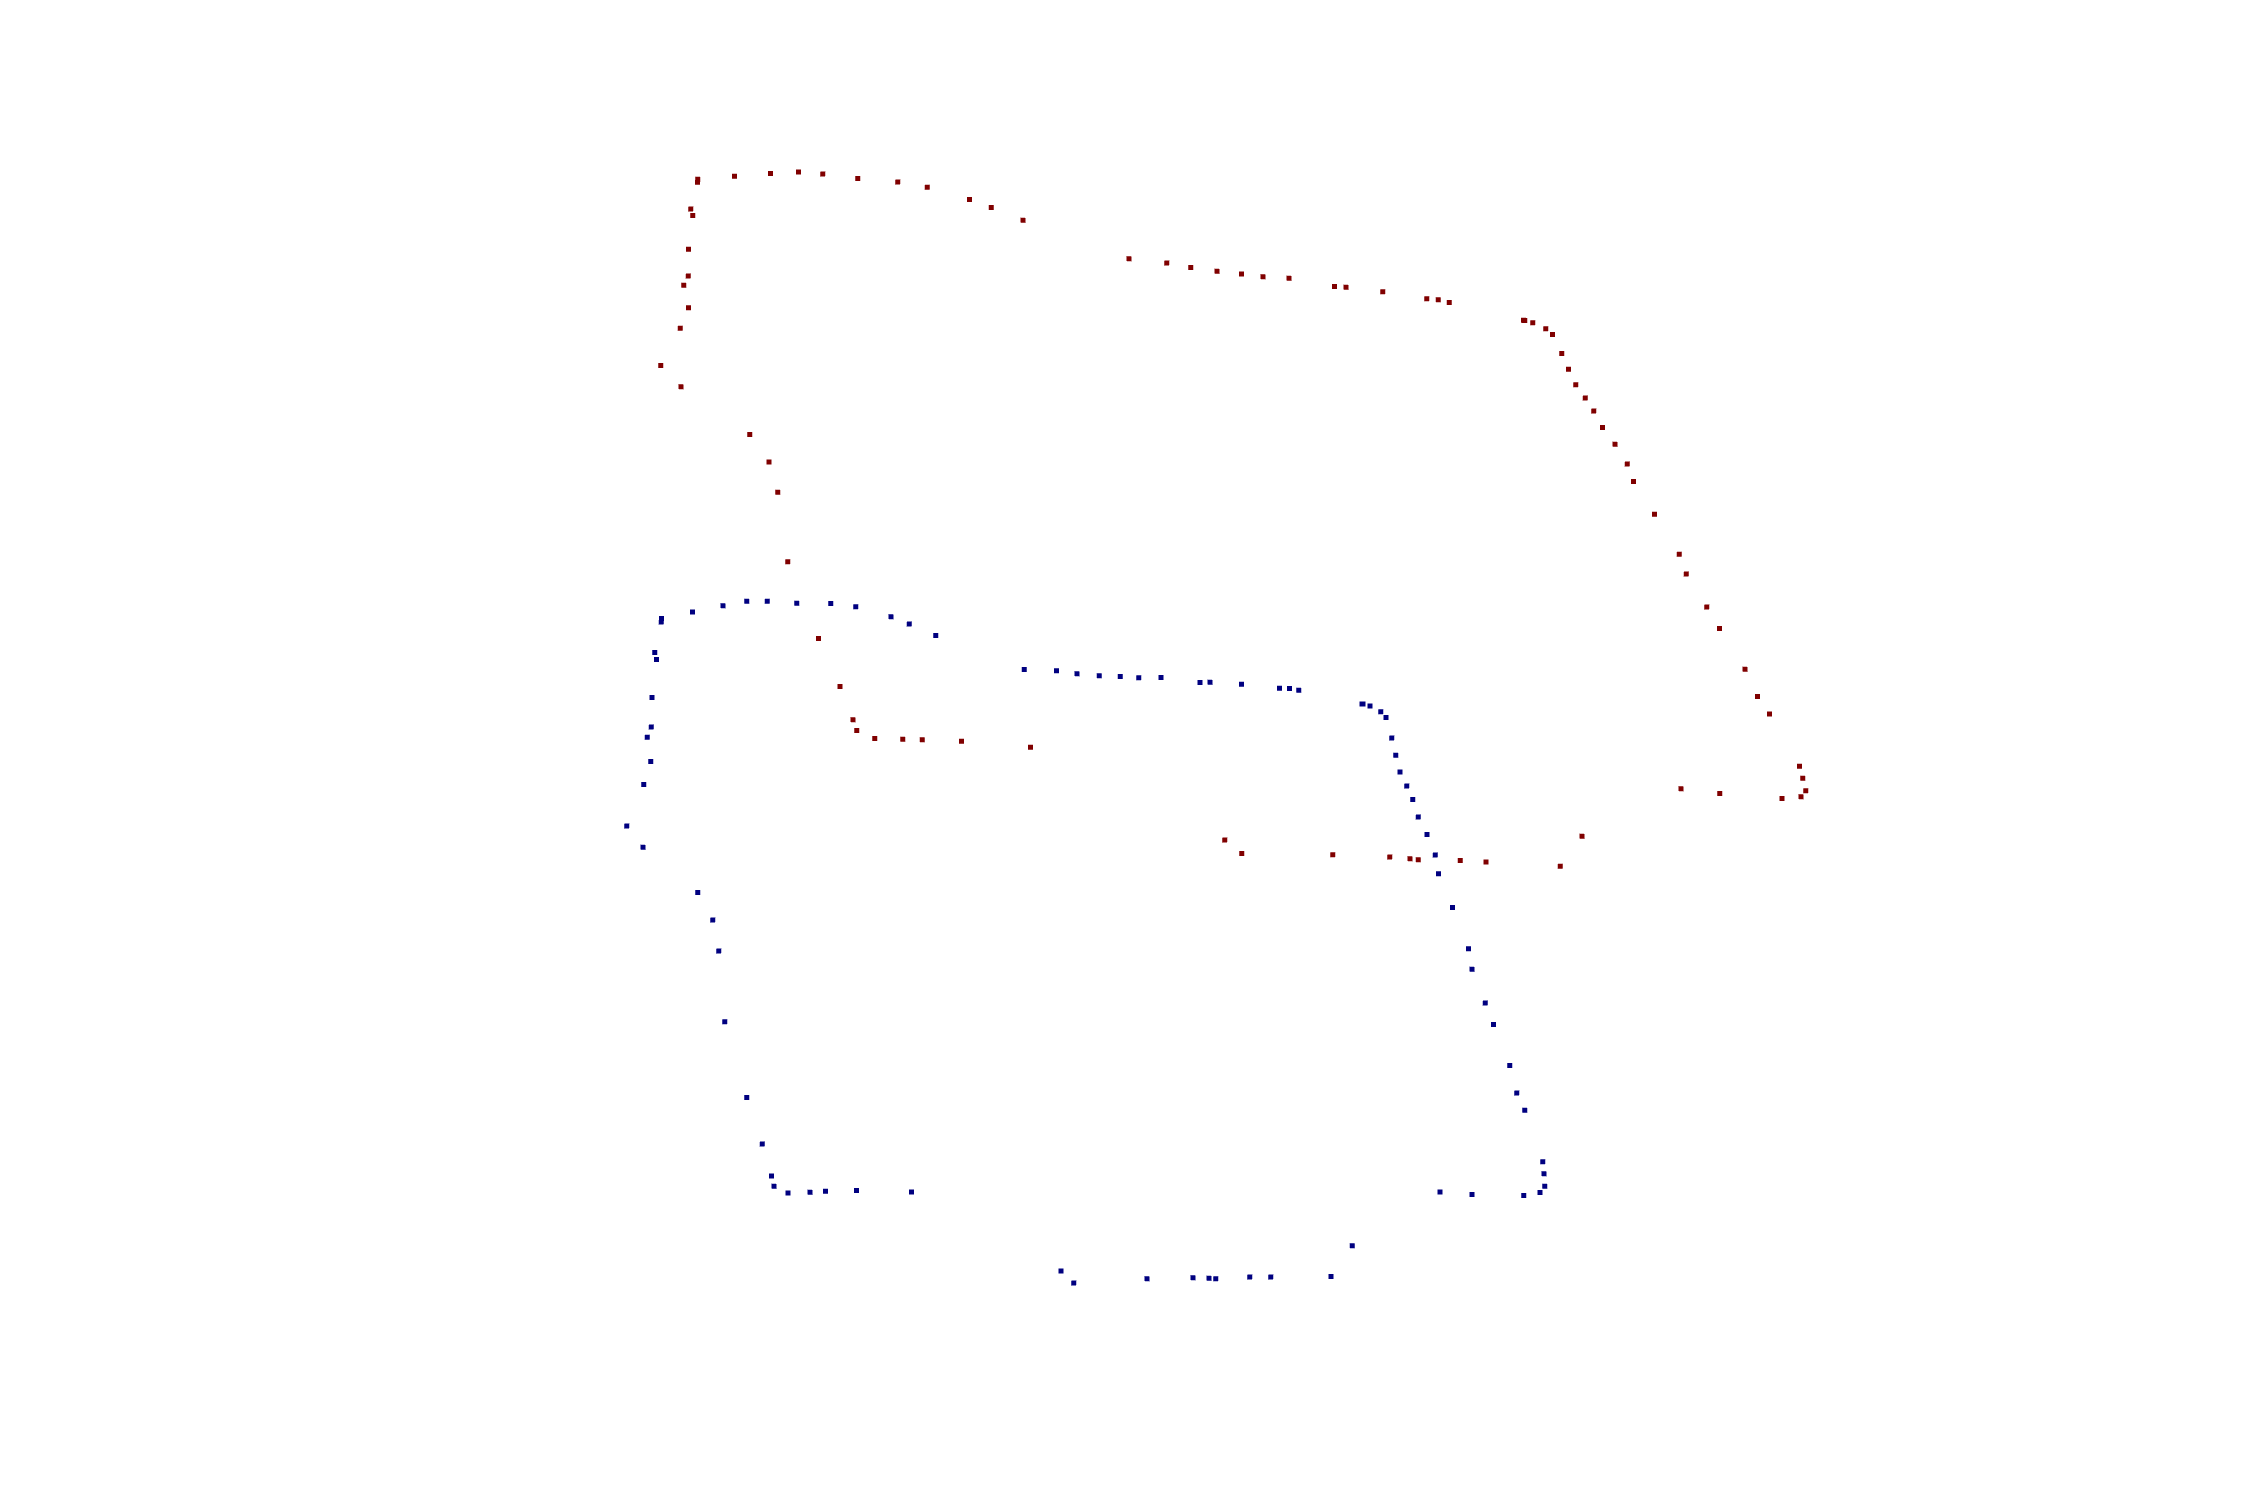

#### 9. Generating the base vertices for the 3D Mesh with Numpy

In [39]:
a = np.array(building_vector.exterior.coords)
b = np.ones([a.shape[0],1])*sample.get_center()[2]
c = np.ones([a.shape[0],1])*(sample.get_center()[2] + height)

In [40]:
#Define the ground footprint and the height arrays of points
ground_pc = np.hstack((a, b))
up_pc = np.hstack((a, c))

In [41]:
#Generate an Open3D "point cloud" made of the major points
temp_o3d = o3d.geometry.PointCloud()
temp_o3d.points = o3d.utility.Vector3dVector(np.concatenate((ground_pc, up_pc), axis=0))

In [42]:
#visualise
o3d.visualization.draw_geometries([temp_o3d])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


#### 10. Computing the alpha Shape of the 3D base points

In [43]:
alpha = 20
print(f"alpha={alpha:.3f}")
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(temp_o3d, alpha)
mesh.compute_vertex_normals()
mesh.paint_uniform_color([0.5,0.4,0])

alpha=20.000
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra

TriangleMesh with 176 points and 612 triangles.

In [44]:
#Visualize
o3d.visualization.draw_geometries([temp_o3d, mesh, segment], mesh_show_back_face=True)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


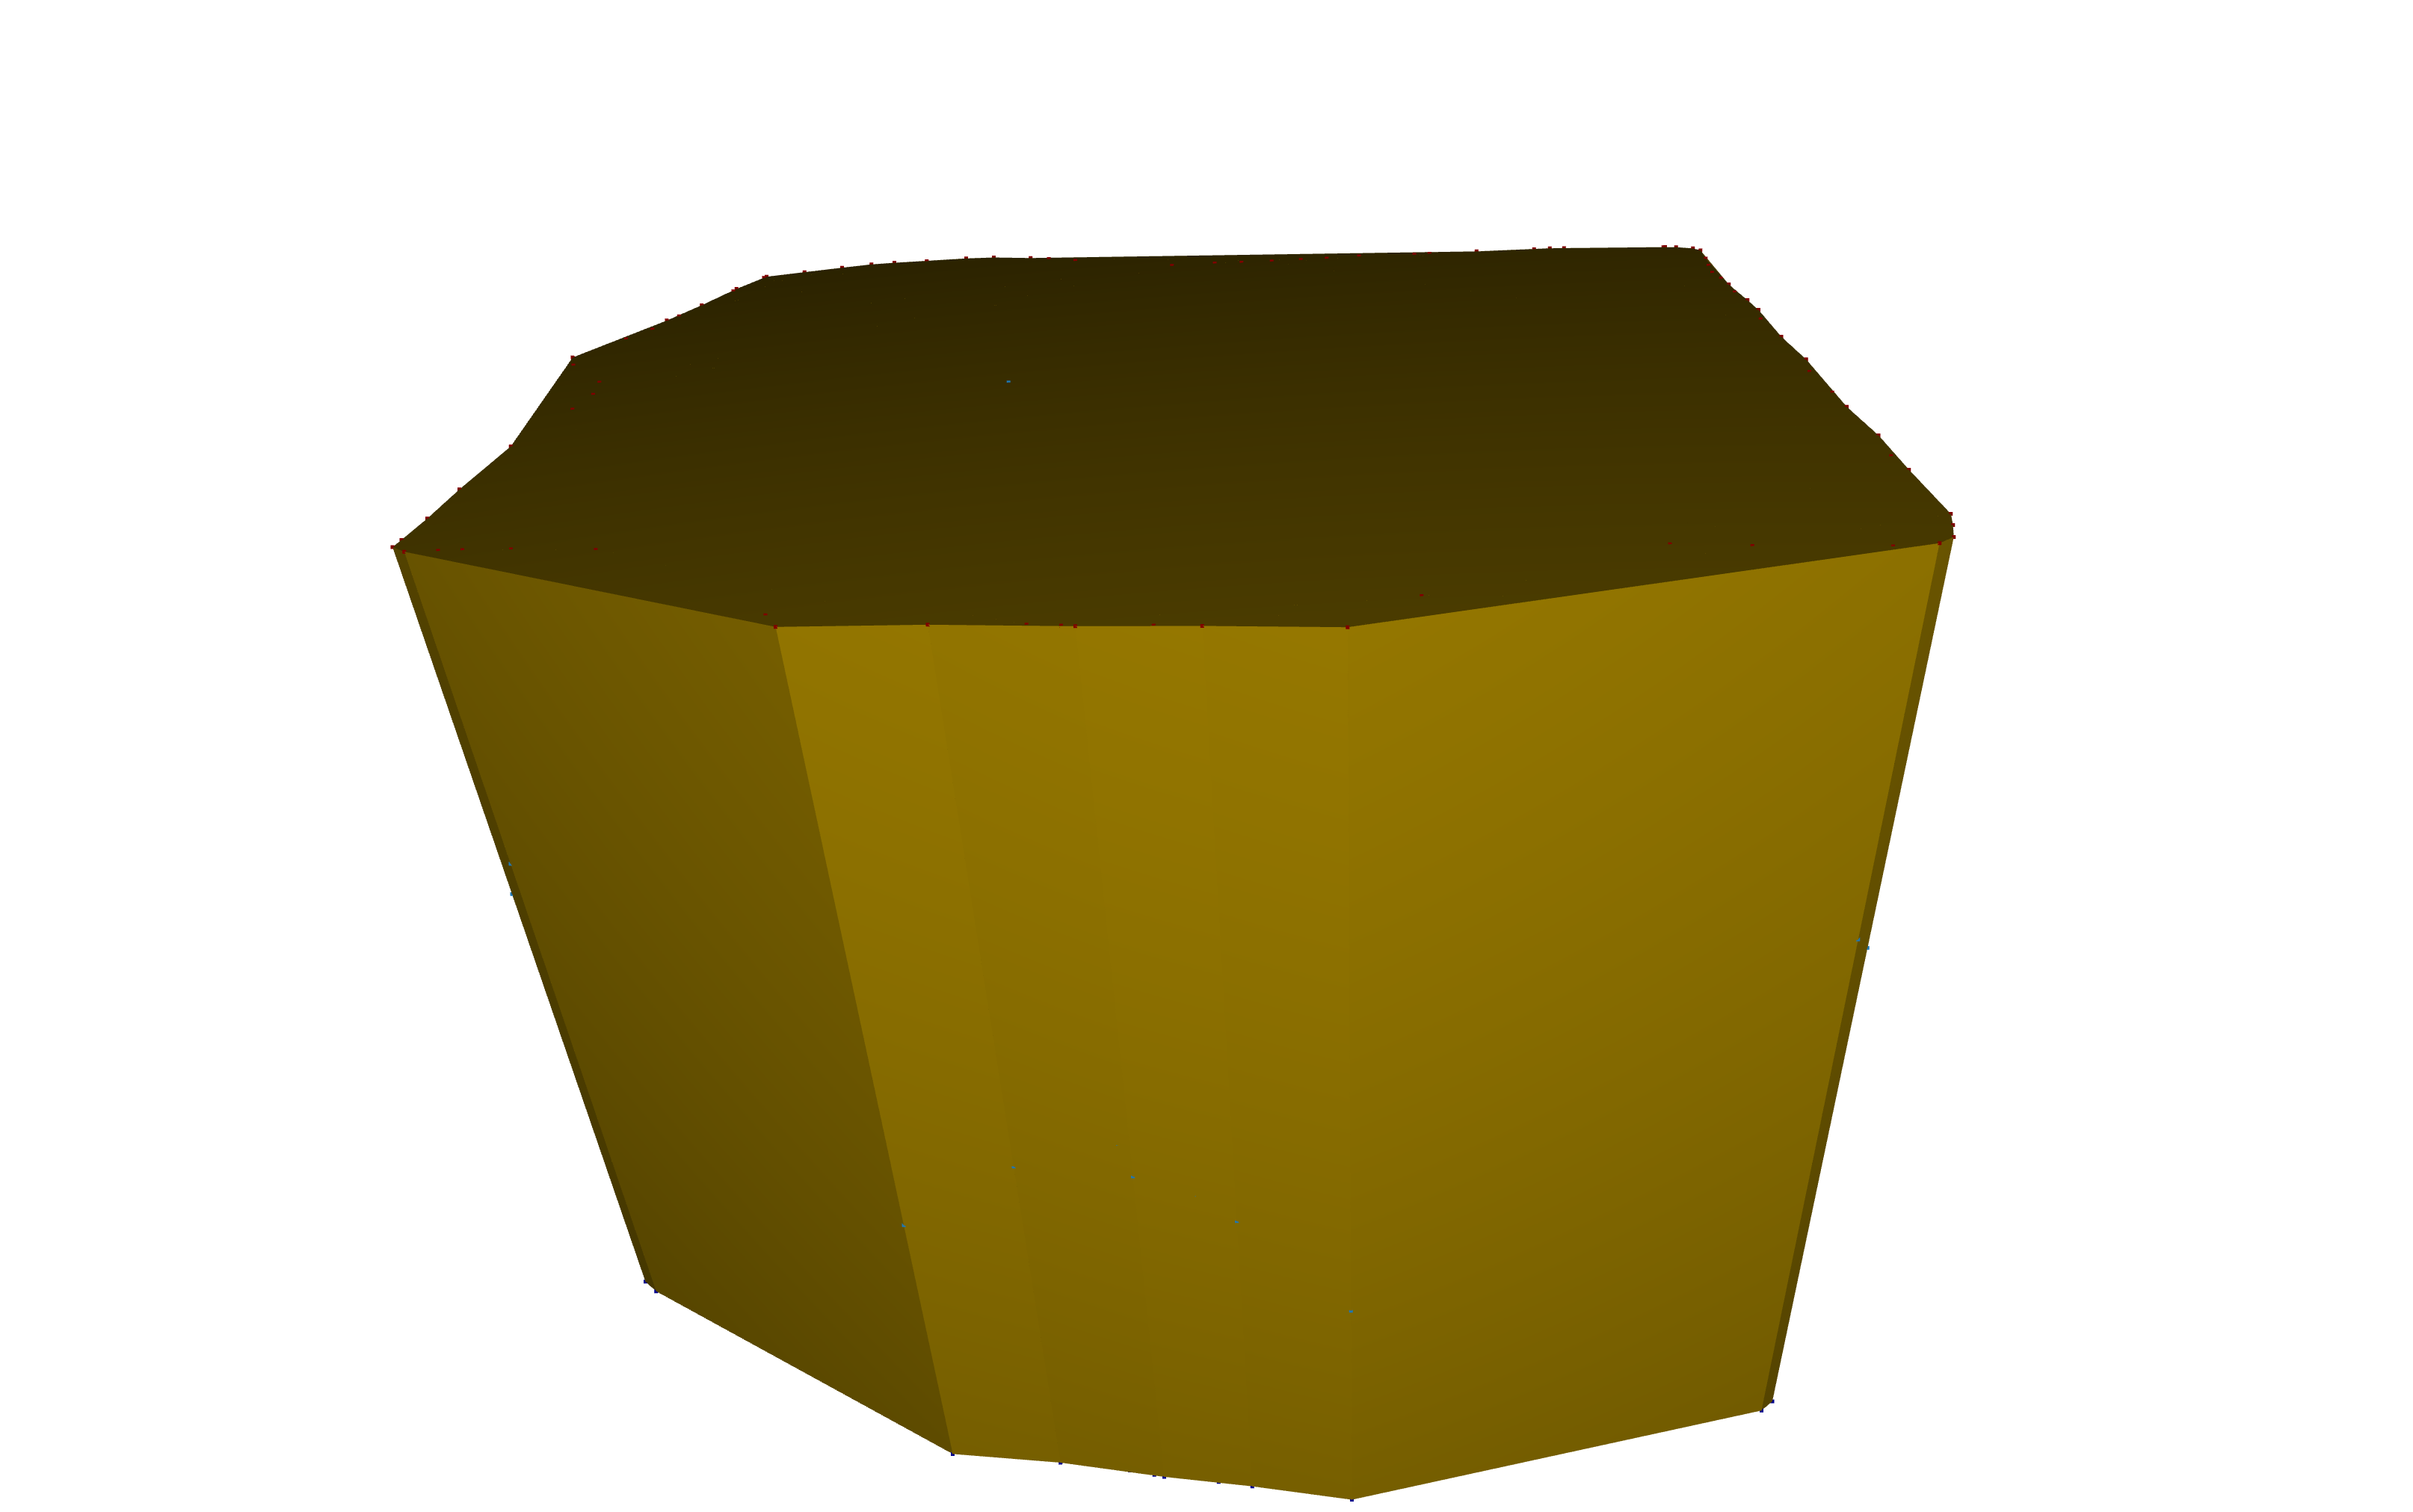
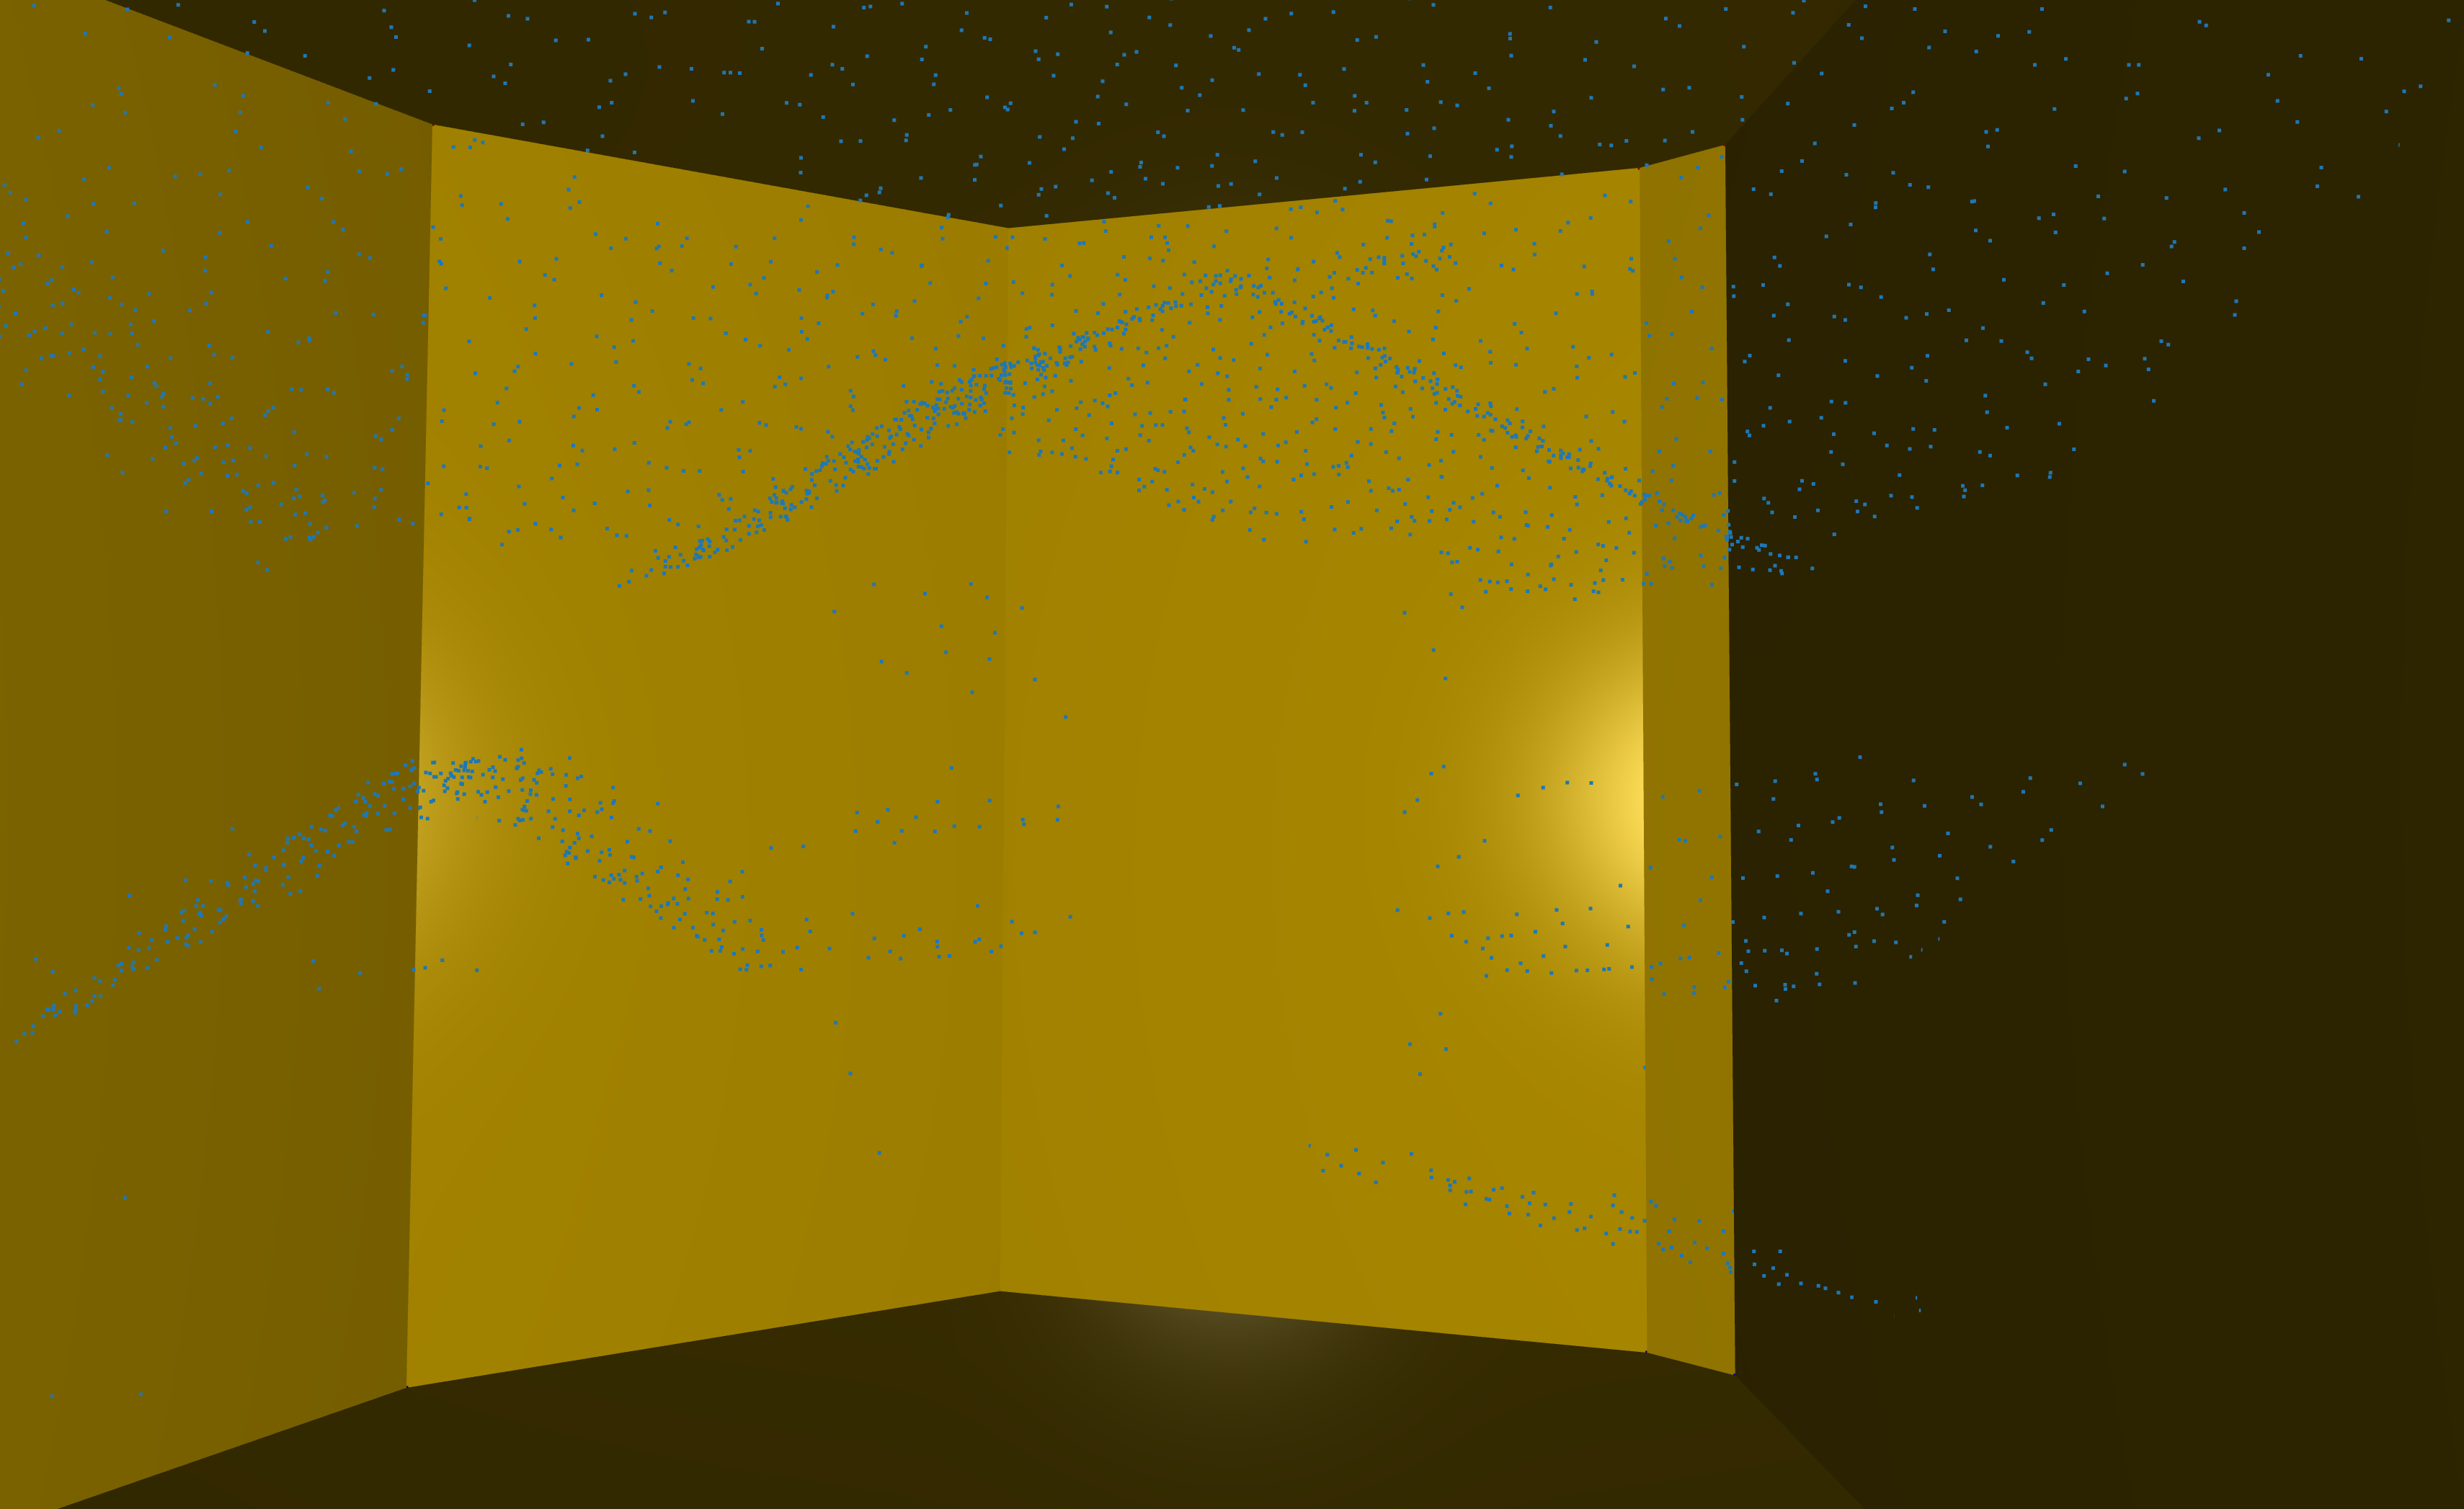

#### 11. Post-Processing Operations & Export

In [45]:
#Repositioning the mesh from local to the world coordinates
mesh.translate(pcd_center)

TriangleMesh with 176 points and 612 triangles.

In [46]:
#Export the Mesh
o3d.io.write_triangle_mesh('/Users/aaryanbabuta/Documents/LiDAR Project/PLY Mesh Files/house_sample.ply', mesh, write_ascii=False, compressed=True, write_vertex_normals=False, write_vertex_colors=False, write_triangle_uvs=False)

True

In [47]:
#Export the shapefile
building_gdf.to_file("/Users/aaryanbabuta/Documents/LiDAR Project/PLY Mesh Files/single_building.shp")

## Phase 4: Automation and Scaling

#### 12. Automation and Scaling 3D City Modelling

In [ ]:
# Optional utility
import random
def random_color_generator():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return [r/255, g/255, b/255]

In [ ]:
#Initializing the GeodataFrame
buildings_gdf = gpd.GeoDataFrame(columns=['id', 'geometry', 'height', 'area', 'perimeter', 'local_cx', 'local_cy', 'local_cz', 'transl_x', 'transl_y', 'transl_z'], geometry='geometry', crs='EPSG:26910')

In [ ]:
# Reducing the output wave of Open3D
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)

In [ ]:
#Creating the loop
for sel in range(max_label+1):
    #1. Select the Segment
    segment = pcd_o3d.select_by_index(np.where(labels==sel)[0])
    # o3d.visualization.draw_geometries([segment])

    #2. Compute the building footprint
    # altitude = np.asarray(segment.points)[:,2]+pcd_center[2]
    points_2D = np.asarray(segment.points)[:,0:2]
    building_vector = ash.alphashape(points_2D, alpha=0.5)
    
    #3. Compute the height of the segment (house candidate).
    query_point = segment.get_center()
    query_point[2] = segment.get_min_bound()[2]
    pcd_tree = o3d.geometry.KDTreeFlann(ground_pts)
    [k, idx, _] = pcd_tree.search_knn_vector_3d(query_point, 50)
    sample = ground_pts.select_by_index(idx, invert=False)
    ground_zero = sample.get_center()[2]
    
    #4. Create the geopandas with attributes entry
    building_gdf = gpd.GeoDataFrame(geometry=[building_vector], crs='EPSG:26910')
    building_gdf[['id']] = sel
    building_gdf[['height']] = segment.get_max_bound()[2] - sample.get_center()[2]
    building_gdf[['area']] = building_vector.area
    building_gdf[['perimeter']] = building_vector.length
    building_gdf[['local_cx','local_cy','local_cz']] = np.asarray([building_vector.centroid.x, building_vector.centroid.y, sample.get_center()[2]])
    building_gdf[['transl_x','transl_y','transl_z']] = pcd_center
    building_gdf[['pts_number']] = len(segment.points)
    
    #4. Add it to geometries entries
    buildings_gdf = pd.concat([buildings_gdf, building_gdf])

    #5. Compute the 3D Vertices Geometries
    a = np.array(building_vector.exterior.coords)
    b = np.ones([a.shape[0],1])*sample.get_center()[2]
    c = np.ones([a.shape[0],1])*(sample.get_center()[2] + height)
    ground_pc = np.hstack((a, b))
    up_pc = np.hstack((a, c))
    temp_o3d = o3d.geometry.PointCloud()
    temp_o3d.points = o3d.utility.Vector3dVector(np.concatenate((ground_pc, up_pc), axis=0))
    
    #5. Compute the 3D Geometry of a house 
    alpha = 20
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(temp_o3d, alpha)
    mesh.translate(pcd_center)
    mesh.paint_uniform_color(random_color_generator())    #5. Compute the 3D Vertices Geometries

    #Note the written file will be a triangular mesh
    o3d.io.write_triangle_mesh('/Users/aaryanbabuta/Documents/LiDAR Project/PLY Mesh Files/house_'+str(sel)+'.ply', mesh, write_ascii=False, compressed=True, write_vertex_normals=False)

In [ ]:
buildings_gdf.head(5)

In [ ]:
#Exporting the geometry are in a local frame of reference
buildings_gdf.to_file("/Users/aaryanbabuta/Documents/LiDAR Project/PLY Mesh Files/neighborhood_buildings.shp")

#### 13. A Raster Variant

In [ ]:
pixel_size = 1

x, y, z = xyz_t[0], xyz_t[1], xyz_t[2]

# Determine the extent of the DEM
min_x, max_x = np.min(x), np.max(x)
min_y, max_y = np.min(y), np.max(y)

# Calculate the number of pixels in X and Y directions
num_pixels_x = int((max_x - min_x) / pixel_size)
num_pixels_y = int((max_y - min_y) / pixel_size)

#profile the results
print("number of pixel along X and Y: ",num_pixels_x, num_pixels_y)

In [ ]:
# Create a transformation for the GeoTIFF
transform = from_origin(min_x, max_y, pixel_size, pixel_size)

# Create an array to store the elevation values
dem_array = np.zeros((num_pixels_y, num_pixels_x), dtype=np.float32)

In [ ]:
# Convert X, Y coordinates to pixel indices
col_indices = ((x - min_x) / pixel_size).astype(int)
row_indices = ((max_y - y) / pixel_size).astype(int)

# Mask to ensure indices are within bounds
valid_indices = (0 <= row_indices) & (row_indices < num_pixels_y) & (0 <= col_indices) & (col_indices < num_pixels_x)

# Populate the DEM array with elevation values from the point cloud
dem_array[row_indices[valid_indices], col_indices[valid_indices]] = z[valid_indices]

In [ ]:
dem_array

In [ ]:
# Save the DEM as a GeoTIFF file
with rasterio.open("/Users/aaryanbabuta/Documents/LiDAR Project/PLY Mesh Files/output_dem.tif", 'w', driver='GTiff', height=num_pixels_y, width=num_pixels_x,
                   count=1, dtype=np.float32, crs='EPSG:26910', transform=transform) as dst:
    dst.write(dem_array, 1)

In [ ]:
from rasterio.features import shapes
from shapely.geometry import Polygon
mask = None
with rasterio.Env():
 with rasterio.open("/Users/aaryanbabuta/Documents/LiDAR Project/PLY Mesh Files/output_dem.tif") as src:
     image = src.read(1) # first band
     results = (
     {'properties': {'raster_val': v}, 'geometry': s}
     for i, (s, v)
     in enumerate(
     shapes(image.astype(np.float32), mask=mask, transform=src.transform))
     )
 
 geoms = list(results)

In [ ]:
import geopandas as gpd
gdf = gpd.GeoDataFrame.from_features(geoms)